# 🧠 Análisis de la Readmisión a la UCI en Pacientes con Hemorragia Intracerebral (MIMIC-IV)

### 1. 🔧 Configuración Inicial
- Conexión a Google BigQuery.
- Autenticación con claves de servicio.
- Preparación del entorno.

In [23]:
%reset -f


from google.cloud import bigquery
from google.oauth2 import service_account

# Path to your service account key file
SERVICE_ACCOUNT_FILE = "mimic-sergi.json"
PROJECT_ID = "ogi-uci-i61"

# Create credentials and client
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE)

client = bigquery.Client(credentials=credentials, project=PROJECT_ID)

# Example query
query = "SELECT 'Hello, World!' AS greeting"
query_job = client.query(query)

# Fetch results
results = query_job.result()

for row in results:
    print(row.greeting)

Hello, World!


### 2. 📦 Extracción de Datos
Consulta SQL avanzada que incluye:
- Selección de pacientes con diagnóstico ICH (ICD-9: 431, ICD-10: I610–I619).
- Variables clínicas: signos vitales, laboratorio, escalas (GCS, APS-III).
- Diagnósticos y tratamientos: hipertensión, neurocirugía, anticoagulantes, etc.
- Cálculo de:
  - Número de estancias en UCI por hospitalización.
  - Readmisión posterior en hospitalizaciones diferentes.

> Se exporta como: `mimiciv_ich_readmission_raw.csv`

In [147]:
## Export ICU ICH Cohort from MIMIC-IV to CSV

## SQL query
query = """
WITH ich_admissions AS (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i
  WHERE (i.icd_version = 9 AND i.icd_code = '431')
     OR (i.icd_version = 10 AND i.icd_code IN ('I610','I611','I612','I613','I614','I615','I616','I618','I619'))
),

chartevents_avg AS (
  SELECT
    c.stay_id,
    AVG(CASE WHEN itemid = 220045 AND valuenum > 0 THEN valuenum END) AS heart_rate_avg,
    AVG(CASE WHEN itemid = 220052 AND valuenum BETWEEN 30 AND 200 THEN valuenum END) AS mbp_avg,
    AVG(CASE WHEN itemid = 220210 AND valuenum BETWEEN 5 AND 60 THEN valuenum END) AS resp_rate_avg,
    AVG(CASE WHEN itemid = 220277 AND valuenum BETWEEN 70 AND 100 THEN valuenum END) AS spo2_avg,
    AVG(CASE WHEN itemid = 220602 AND valuenum IS NOT NULL THEN valuenum END) AS chloride_avg,
    AVG(CASE WHEN itemid = 220615 AND valuenum IS NOT NULL THEN valuenum END) AS creatinine_avg,
    AVG(CASE WHEN itemid = 220645 AND valuenum IS NOT NULL THEN valuenum END) AS sodium_avg
  FROM `ogi-uci-i61.mimiciv_icu.chartevents` c
  JOIN `ogi-uci-i61.mimiciv_icu.icustays` i ON c.stay_id = i.stay_id
  WHERE c.itemid IN (220045, 220052, 220210, 220277, 220602, 220615, 220645)
    AND c.valuenum IS NOT NULL
    AND c.charttime BETWEEN i.intime AND i.outtime
  GROUP BY c.stay_id
),

cbc_labs AS (
  SELECT
    subject_id,
    hadm_id,
    AVG(wbc) AS wbc_avg,
    MIN(hemoglobin) AS hgb_min
  FROM `ogi-uci-i61.mimiciv_derived.complete_blood_count`
  GROUP BY subject_id, hadm_id
),

chem_labs AS (
  SELECT
    subject_id,
    hadm_id,
    AVG(glucose) AS glucose_avg
  FROM `ogi-uci-i61.mimiciv_derived.chemistry`
  GROUP BY subject_id, hadm_id
),

coag_labs AS (
  SELECT
    subject_id,
    hadm_id,
    MAX(inr) AS inr_max,
    MAX(pt) AS pt_max
  FROM `ogi-uci-i61.mimiciv_derived.coagulation`
  GROUP BY subject_id, hadm_id
),

labevents AS (
  SELECT
    subject_id,
    hadm_id,
    AVG(CASE WHEN itemid = 51249 THEN valuenum END) AS mchc_avg,
    AVG(CASE WHEN itemid = 51254 THEN valuenum END) AS monocytes_avg,
    AVG(CASE WHEN itemid = 51256 THEN valuenum END) AS neutrophils_avg,
    AVG(CASE WHEN itemid = 50861 THEN valuenum END) AS alt_avg
  FROM `ogi-uci-i61.mimiciv_hosp.labevents`
  WHERE itemid IN (51249, 51254, 51256, 50861) AND valuenum IS NOT NULL
  GROUP BY subject_id, hadm_id
),

icu_stay_counts AS (
  SELECT
    hadm_id,
    COUNT(*) AS icu_stays_in_admission
  FROM `ogi-uci-i61.mimiciv_icu.icustays`
  GROUP BY hadm_id
)

SELECT
  a.subject_id,
  a.hadm_id,
  a.stay_id,
  p.gender,
  p.anchor_age AS age,
  a.intime,
  a.outtime,
  a.first_careunit,
  TIMESTAMP_DIFF(a.outtime, a.intime, HOUR) AS icu_los_hours,
  TIMESTAMP_DIFF(adm.dischtime, adm.admittime, HOUR) AS hosp_los_hours,
  adm.discharge_location,
  adm.hospital_expire_flag,

  STRING_AGG(CASE WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN i.icd_code END, '; ') AS ich_icd_codes,
  STRING_AGG(CASE
               WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN CONCAT(i.icd_code, ': ', d.long_title)
               ELSE i.icd_code
             END, '; ') AS all_diagnoses,

  s.gcs_verbal,
  s.gcs_motor,
  s.gcs_eyes,

  ce.heart_rate_avg,
  ce.mbp_avg,
  ce.resp_rate_avg,
  ce.spo2_avg,
  ce.chloride_avg,
  ce.creatinine_avg,
  ce.sodium_avg,

  charlson.charlson_comorbidity_index,
  apsi.apsiii,
  cbc.wbc_avg,
  cbc.hgb_min,
  chem.glucose_avg,
  coag.inr_max,
  coag.pt_max,
  lab.mchc_avg,
  lab.monocytes_avg,
  lab.neutrophils_avg,
  lab.alt_avg,

  CASE WHEN hyper.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hypertension,
  CASE WHEN hydro.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hydrocephalus,
  CASE WHEN cad.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_cad,
  CASE WHEN anticoag.subject_id IS NOT NULL THEN 1 ELSE 0 END AS has_anticoagulation,
  CASE WHEN neuroproc.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS had_neurosurgery,
  CASE WHEN addmeds.subject_id IS NOT NULL THEN 1 ELSE 0 END AS on_statins_or_antiplatelets,

  icucount.icu_stays_in_admission,
  CASE WHEN icucount.icu_stays_in_admission > 1 THEN 1 ELSE 0 END AS readmitted_within_hospital_stay,

  readmit.readmitted_stay,
  CASE WHEN hosp_readmit.next_admission_time IS NOT NULL THEN 1 ELSE 0 END AS readmitted_to_hospital

FROM `ogi-uci-i61.mimiciv_icu.icustays` a
JOIN `ogi-uci-i61.mimiciv_hosp.patients` p ON a.subject_id = p.subject_id
JOIN `ogi-uci-i61.mimiciv_hosp.admissions` adm ON a.hadm_id = adm.hadm_id
JOIN ich_admissions ich ON a.hadm_id = ich.hadm_id

LEFT JOIN `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i ON a.hadm_id = i.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses` d ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version

LEFT JOIN (
  SELECT
    stay_id,
    NULLIF(gcs_verbal, 0) AS gcs_verbal,
    NULLIF(gcs_motor, 0) AS gcs_motor,
    NULLIF(gcs_eyes, 0) AS gcs_eyes,
    ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM `ogi-uci-i61.mimiciv_derived.gcs`
) s ON a.stay_id = s.stay_id AND s.rn = 1

LEFT JOIN chartevents_avg ce ON a.stay_id = ce.stay_id

LEFT JOIN (
  SELECT
    a1.subject_id,
    a1.stay_id,
    MIN(a2.stay_id) AS readmitted_stay
  FROM `ogi-uci-i61.mimiciv_icu.icustays` a1
  JOIN `ogi-uci-i61.mimiciv_icu.icustays` a2
    ON a1.subject_id = a2.subject_id AND a2.intime > a1.outtime AND a1.hadm_id != a2.hadm_id
  GROUP BY a1.subject_id, a1.stay_id
) readmit ON a.subject_id = readmit.subject_id AND a.stay_id = readmit.stay_id

-- NEW: Readmission to hospital
LEFT JOIN (
  SELECT
    a1.subject_id,
    a1.hadm_id,
    MIN(a2.admittime) AS next_admission_time
  FROM `ogi-uci-i61.mimiciv_hosp.admissions` a1
  JOIN `ogi-uci-i61.mimiciv_hosp.admissions` a2
    ON a1.subject_id = a2.subject_id
   AND a2.admittime > a1.dischtime
  GROUP BY a1.subject_id, a1.hadm_id
) hosp_readmit ON a.hadm_id = hosp_readmit.hadm_id

LEFT JOIN `ogi-uci-i61.mimiciv_derived.charlson` charlson ON a.hadm_id = charlson.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_derived.apsiii` apsi ON a.stay_id = apsi.stay_id
LEFT JOIN cbc_labs cbc ON a.subject_id = cbc.subject_id AND a.hadm_id = cbc.hadm_id
LEFT JOIN chem_labs chem ON a.subject_id = chem.subject_id AND a.hadm_id = chem.hadm_id
LEFT JOIN coag_labs coag ON a.subject_id = coag.subject_id AND a.hadm_id = coag.hadm_id
LEFT JOIN labevents lab ON a.subject_id = lab.subject_id AND a.hadm_id = lab.hadm_id
LEFT JOIN icu_stay_counts icucount ON a.hadm_id = icucount.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '401%' OR icd_code LIKE 'I10%'
) hyper ON a.hadm_id = hyper.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '331.3' OR icd_code LIKE 'G91%'
) hydro ON a.hadm_id = hydro.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '414%' OR icd_code LIKE 'I25%'
) cad ON a.hadm_id = cad.hadm_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM `ogi-uci-i61.mimiciv_hosp.prescriptions`
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(warfarin|heparin|apixaban|rivaroxaban|dabigatran)')
    AND drug_type = 'MAIN'
) anticoag ON a.subject_id = anticoag.subject_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM `ogi-uci-i61.mimiciv_hosp.prescriptions`
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(aspirin|clopidogrel|atorvastatin|rosuvastatin)')
    AND drug_type = 'MAIN'
) addmeds ON a.subject_id = addmeds.subject_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.procedures_icd`
  WHERE icd_code LIKE '01%' OR icd_code LIKE '02%'
) neuroproc ON a.hadm_id = neuroproc.hadm_id

GROUP BY
  a.subject_id, a.hadm_id, a.stay_id, a.intime, a.outtime, a.first_careunit,
  p.gender, p.anchor_age,
  adm.admittime, adm.dischtime, adm.discharge_location, adm.hospital_expire_flag,
  s.gcs_verbal, s.gcs_motor, s.gcs_eyes,
  ce.heart_rate_avg, ce.mbp_avg, ce.resp_rate_avg, ce.spo2_avg, ce.chloride_avg, ce.creatinine_avg, ce.sodium_avg,
  charlson.charlson_comorbidity_index,
  apsi.apsiii,
  cbc.wbc_avg, cbc.hgb_min,
  chem.glucose_avg,
  coag.inr_max, coag.pt_max,
  lab.mchc_avg, lab.monocytes_avg, lab.neutrophils_avg, lab.alt_avg,
  hyper.hadm_id, hydro.hadm_id, cad.hadm_id,
  anticoag.subject_id, addmeds.subject_id, neuroproc.hadm_id,
  icucount.icu_stays_in_admission,
  readmit.readmitted_stay,
  hosp_readmit.next_admission_time
"""

# Execute Query and Export to CSV
df = client.query(query).to_dataframe()
df.to_csv("data/mimiciv_ich_readmission_raw.csv", index=False)
print("✅ Exported to mimiciv_ich_readmission_raw.csv")

df


✅ Exported to mimiciv_ich_readmission_raw.csv


,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,has_hypertension,has_hydrocephalus,has_cad,has_anticoagulation,had_neurosurgery,on_statins_or_antiplatelets,icu_stays_in_admission,readmitted_within_hospital_stay,readmitted_stay,readmitted_to_hospital
0,16877448,20539272,32961547,F,36,2178-04-18 07:13:00,2178-05-01 15:27:37,Neuro Intermediate,320,321,...,1,1,0,1,0,1,1,0,32120892,1
1,14417339,28899895,31962512,M,87,2166-01-06 12:41:00,2166-01-11 15:42:43,Medical Intensive Care Unit (MICU),123,124,...,0,0,0,0,1,0,1,0,38823653,1
2,19815419,28492166,34194602,M,38,2135-04-29 22:04:00,2135-05-15 21:59:21,Neuro Surgical Intensive Care Unit (Neuro SICU),383,501,...,1,1,0,1,0,1,1,0,<NA>,0
3,13697655,25956563,39596333,M,61,2151-09-16 12:35:02,2151-09-20 19:30:03,Neuro Intermediate,103,103,...,1,0,0,1,0,1,1,0,<NA>,0
4,16114640,26904413,34820828,M,65,2150-07-14 02:21:00,2150-07-15 13:22:35,Surgical Intensive Care Unit (SICU),35,135,...,1,0,1,1,0,1,1,0,38397763,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3616,14513810,22990666,38761227,F,71,2179-05-01 22:00:01,2179-05-04 03:10:43,Coronary Care Unit (CCU),53,52,...,0,0,0,1,1,1,1,0,<NA>,0
3617,15506447,29997128,37114286,M,83,2139-03-20 01:47:00,2139-03-23 14:38:01,Neuro Intermediate,85,158,...,0,0,0,1,0,0,1,0,38137185,1
3618,14611397,26401269,33142776,M,84,2173-05-31 21:17:00,2173-06-19 01:37:51,Neuro Surgical Intensive Care Unit (Neuro SICU),436,433,...,0,1,1,1,0,1,1,0,<NA>,0
3619,13715870,20728952,36580188,M,73,2174-02-25 04:04:23,2174-03-01 18:22:49,Surgical Intensive Care Unit (SICU),110,262,...,1,0,1,1,0,1,1,0,37642962,1


In [25]:

# Display the columns of the DataFrame

print(df.columns)

Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'age', 'intime',
       'outtime', 'first_careunit', 'icu_los_hours', 'hosp_los_hours',
       'discharge_location', 'hospital_expire_flag', 'ich_icd_codes',
       'all_diagnoses', 'gcs_verbal', 'gcs_motor', 'gcs_eyes',
       'heart_rate_avg', 'mbp_avg', 'resp_rate_avg', 'spo2_avg',
       'chloride_avg', 'creatinine_avg', 'sodium_avg',
       'charlson_comorbidity_index', 'apsiii', 'wbc_avg', 'hgb_min',
       'glucose_avg', 'inr_max', 'pt_max', 'mchc_avg', 'monocytes_avg',
       'neutrophils_avg', 'alt_avg', 'has_hypertension', 'has_hydrocephalus',
       'has_cad', 'has_anticoagulation', 'had_neurosurgery',
       'on_statins_or_antiplatelets', 'icu_stays_in_admission',
       'readmitted_within_hospital_stay', 'readmitted_stay',
       'readmitted_to_hospital'],
      dtype='object')


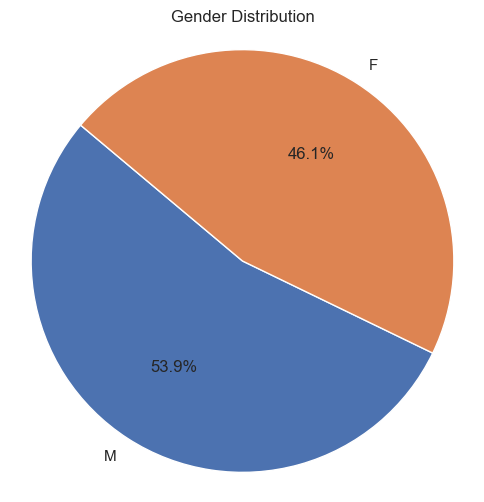

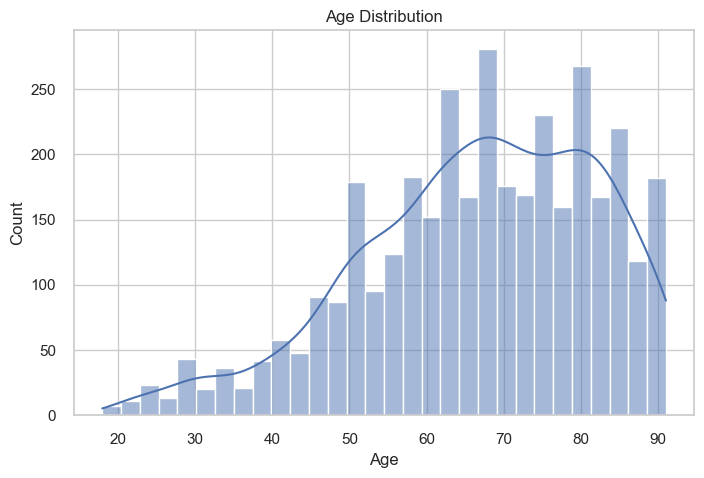

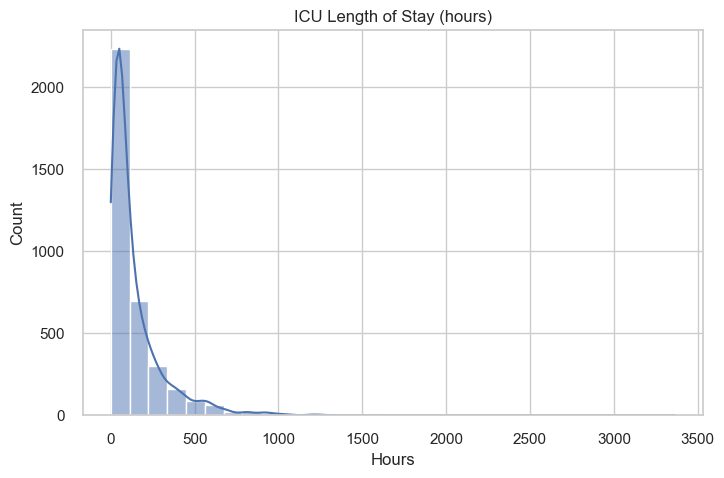

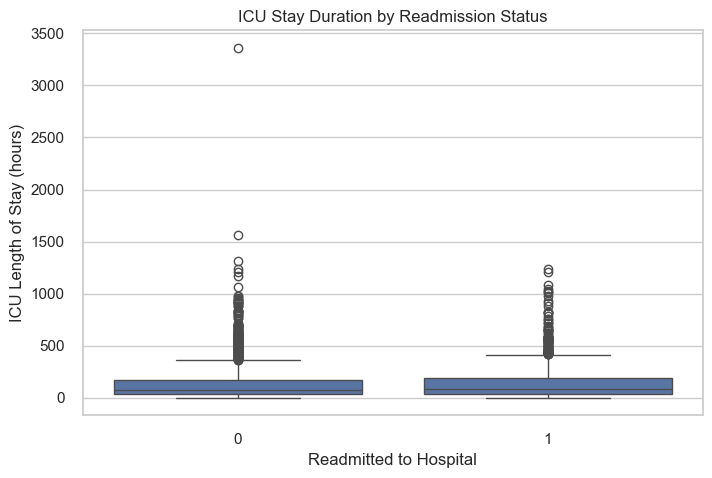

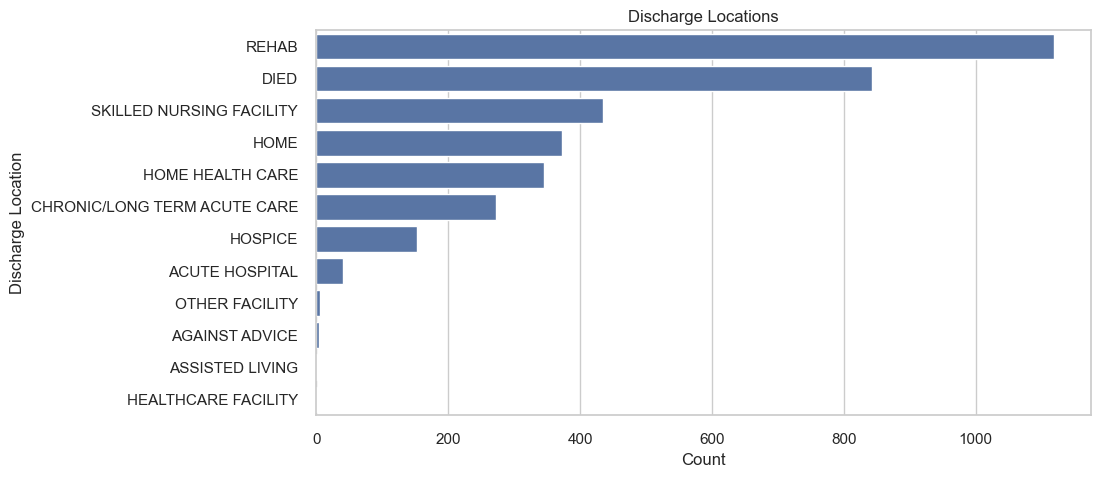

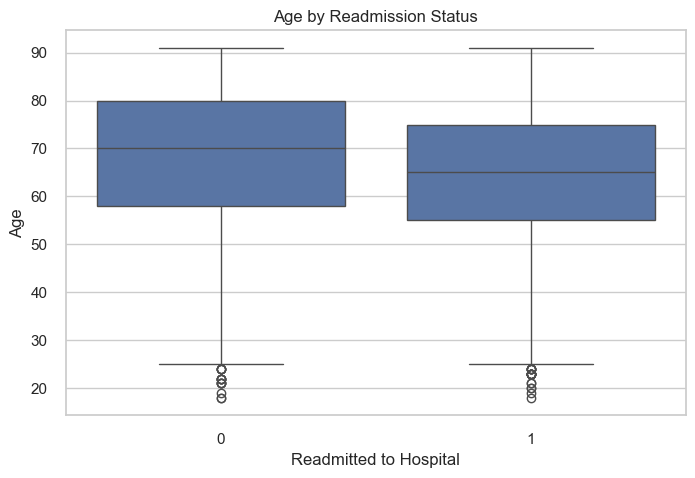

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the clean dataset
df = pd.read_csv("data/mimiciv_ich_readmission_raw.csv")

# Set styles
sns.set(style="whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

# Convert necessary columns to categorical for plotting
df['gender'] = df['gender'].astype('category')
df['readmitted_to_hospital'] = df['readmitted_to_hospital'].astype('category')
df['readmitted'] = df['readmitted_to_hospital']
df['discharge_location'] = df['discharge_location'].astype('category')

# Plot 1: Pie chart of gender distribution
gender_counts = df['gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()

# Plot 2: Histogram of age
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Plot 3: Histogram of ICU Length of Stay
plt.figure(figsize=(8, 5))
sns.histplot(df['icu_los_hours'], bins=30, kde=True)
plt.title('ICU Length of Stay (hours)')
plt.xlabel('Hours')
plt.ylabel('Count')
plt.show()

# Plot 4: ICU Length of Stay vs Readmitted to Hospital
plt.figure(figsize=(8, 5))
sns.boxplot(x='readmitted', y='icu_los_hours', data=df)
plt.title('ICU Stay Duration by Readmission Status')
plt.xlabel('Readmitted to Hospital')
plt.ylabel('ICU Length of Stay (hours)')
plt.show()

# Plot 5: Discharge location distribution
plt.figure(figsize=(10, 5))
sns.countplot(y='discharge_location', data=df, order=df['discharge_location'].value_counts().index)
plt.title('Discharge Locations')
plt.xlabel('Count')
plt.ylabel('Discharge Location')
plt.show()

# Plot 6: Age vs Readmission
plt.figure(figsize=(8, 5))
sns.boxplot(x='readmitted', y='age', data=df)
plt.title('Age by Readmission Status')
plt.xlabel('Readmitted to Hospital')
plt.ylabel('Age')
plt.show()

### 3. 🧽 Preprocesamiento

#### 🧹 Limpieza del Dataset
- Manejo de valores nulos.
- Verificación de IDs duplicados o inconsistentes.
- Creación de variable objetivo binaria: `readmitted`.

#### 🧠 Feature Engineering
- Selección estadística de diagnósticos ICD relevantes mediante asociación con readmisión.
- Eliminación de columnas irrelevantes, con muchos nulos o que podrían inducir fuga de datos.

#### 🔬 Imputación de Valores Faltantes
- Evaluación de mecanismo MCAR/MAR/MNAR.
- Imputación basada en el patrón identificado.



In [158]:
import pandas as pd
import numpy as np

df= pd.read_csv("data/mimiciv_ich_readmission_raw.csv")
print(f"✅ Archivo cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

# Remove patients who died in the hospital
df = df[df['hospital_expire_flag'] == 0]
print(f"Remaining patients after removing in-hospital deaths: {len(df)}")

# Remove rows where discharge location is 'DIED'
if 'discharge_location' in df.columns:
    df = df[df['discharge_location'].str.upper() != 'DIED']

# Remove patients who spent less than 24 hours in ICU
#df['icu_los_hours'] = pd.to_numeric(df['icu_los_hours'], errors='coerce')
#df = df[df['icu_los_hours'] >= 24]
#print(f"Remaining patients after filtering ICU stays < 24 hrs: {len(df)}")

# Remove patients under 18 years old
df = df[df['age'] >= 18]
print(f"Remaining patients after filtering patients under 18: {len(df)}")

# Remove rows with negative hospital length of stay
df['hosp_los_hours'] = pd.to_numeric(df['hosp_los_hours'], errors='coerce')
df = df[df['hosp_los_hours'] >= 0]
print(f"Remaining patients after removing negative hospital LOS: {len(df)}")

# Asegurarse de que las columnas GCS son numéricas
gcs_cols = ['gcs_verbal', 'gcs_motor', 'gcs_eyes']
df[gcs_cols] = df[gcs_cols].apply(pd.to_numeric, errors='coerce')


# Confirmar tipos de datos
print(df[gcs_cols].dtypes)

# Drop rows with NA in categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df = df.dropna(subset=categorical_cols)
print(f"Remaining patients after dropping NA in categorical columns: {len(df)}")

# Create target variable
print("\nNulls in readmitted_stay before fillna:", df['readmitted_stay'].isnull().sum())
df['readmitted'] = df['readmitted_stay'].notnull().astype(int)
print("Class distribution in readmitted:", df['readmitted'].value_counts())

# Check ID uniqueness
print(f"\nUnique stay IDs: {df['stay_id'].nunique()}")
print(f"Duplicate stay IDs: {df.duplicated(subset='stay_id').sum()}")
print(f"Unique hadm IDs: {df['hadm_id'].nunique()}")
print(f"Duplicate hadm IDs: {df.duplicated(subset='hadm_id').sum()}")

# Inspect an example if duplicates exist
duplicated_ids = df['stay_id'].value_counts()
if (dupes := duplicated_ids[duplicated_ids > 1]).any():
    sample = dupes.index[0]
    print(f"\nInspecting duplicate stay_id: {sample}")
    differing = df[df['stay_id'] == sample].nunique().loc[lambda x: x > 1].index.tolist()
    print(f"Differing columns: {differing}")
else:
    print("No duplicated stay IDs found.")

df

✅ Archivo cargado: 3621 filas, 45 columnas
Remaining patients after removing in-hospital deaths: 2771
Remaining patients after filtering patients under 18: 2758
Remaining patients after removing negative hospital LOS: 2758
gcs_verbal    float64
gcs_motor     float64
gcs_eyes      float64
dtype: object
Remaining patients after dropping NA in categorical columns: 2747

Nulls in readmitted_stay before fillna: 2236
Class distribution in readmitted: readmitted
0    2236
1     511
Name: count, dtype: int64

Unique stay IDs: 2747
Duplicate stay IDs: 0
Unique hadm IDs: 2437
Duplicate hadm IDs: 310
No duplicated stay IDs found.


,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,has_hydrocephalus,has_cad,has_anticoagulation,had_neurosurgery,on_statins_or_antiplatelets,icu_stays_in_admission,readmitted_within_hospital_stay,readmitted_stay,readmitted_to_hospital,readmitted
0,16877448,20539272,32961547,F,36,2178-04-18 07:13:00,2178-05-01 15:27:37,Neuro Intermediate,320.0,321,...,1,0,1,0,1,1,0,32120892.0,1,1
1,14417339,28899895,31962512,M,87,2166-01-06 12:41:00,2166-01-11 15:42:43,Medical Intensive Care Unit (MICU),123.0,124,...,0,0,0,1,0,1,0,38823653.0,1,1
2,19815419,28492166,34194602,M,38,2135-04-29 22:04:00,2135-05-15 21:59:21,Neuro Surgical Intensive Care Unit (Neuro SICU),383.0,501,...,1,0,1,0,1,1,0,NaN,0,0
3,13697655,25956563,39596333,M,61,2151-09-16 12:35:02,2151-09-20 19:30:03,Neuro Intermediate,103.0,103,...,0,0,1,0,1,1,0,NaN,0,0
4,16114640,26904413,34820828,M,65,2150-07-14 02:21:00,2150-07-15 13:22:35,Surgical Intensive Care Unit (SICU),35.0,135,...,0,1,1,0,1,1,0,38397763.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,18903459,21077260,36623584,F,43,2182-05-22 04:29:00,2182-06-15 15:57:56,Surgical Intensive Care Unit (SICU),587.0,681,...,1,0,1,1,0,1,0,NaN,1,0
3613,15037407,20520887,30280467,M,74,2149-07-04 06:23:00,2149-07-05 14:08:48,Neuro Surgical Intensive Care Unit (Neuro SICU),32.0,82,...,0,0,1,0,1,1,0,NaN,1,0
3614,12148208,20711803,39631432,F,78,2182-11-08 23:27:00,2182-11-11 17:41:31,Neuro Stepdown,66.0,67,...,0,1,1,0,1,1,0,NaN,0,0
3617,15506447,29997128,37114286,M,83,2139-03-20 01:47:00,2139-03-23 14:38:01,Neuro Intermediate,85.0,158,...,0,0,1,0,0,1,0,38137185.0,1,1


### 🎯 Feature Selection from ICD Diagnoses via Statistical Association with Readmission
This section processes the ALL_DIAGNOSES column, extracting individual ICD codes, then runs chi-squared tests to find those significantly associated with ICU readmission.

Only those codes with adjusted p-value < 0.05 are retained as binary features. This reduces dimensionality and improves model interpretability.

In [159]:
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests

# Step 1: Extract individual ICD codes
df['icd_codes'] = df['all_diagnoses'].fillna('').apply(
    lambda s: [x.strip().split(':')[0] for x in s.split(';') if x.strip()]
)

# Step 2: One-hot encode all ICD codes
mlb = MultiLabelBinarizer(sparse_output=False)
icd_df = pd.DataFrame(mlb.fit_transform(df['icd_codes']), columns=mlb.classes_)
icd_df.index = df.index  # ensure alignment

# Step 3: Run chi-squared test for each code vs readmission
pvals = []
target = 'readmitted_within_hospital_stay'

for col in icd_df.columns:
    contingency = pd.crosstab(icd_df[col], df[target])
    if contingency.shape == (2, 2):  # skip if not enough data
        _, p, _, _ = chi2_contingency(contingency)
        pvals.append((col, p))

# --- Settings ---
TOP_N_ICD_CODES = 50  # 👈 Change this value to use top N ICD codes

# Step 4: Adjust for multiple testing
import pandas as pd  # if not already imported
from statsmodels.stats.multitest import multipletests

results_df = pd.DataFrame(pvals, columns=['icd_code', 'pval'])

# Total number of tests (m)
m = len(results_df)

# Apply Benjamini-Hochberg (FDR)
adjusted_pvals = multipletests(results_df['pval'], method='fdr_bh')[1]
results_df['adj_pval'] = adjusted_pvals

# Add rank and sort
results_df['rank_i'] = results_df['pval'].rank(method='min').astype(int)
results_df['m'] = m
results_df = results_df.sort_values(by='adj_pval')

# Step 5: Keep only top N significant codes
top_significant = results_df.head(TOP_N_ICD_CODES)
significant_codes = top_significant['icd_code'].tolist()
icd_df_filtered = icd_df[significant_codes]

df['diagnosis_count'] = df['all_diagnoses'].fillna('').apply(
    lambda s: len([x for x in s.split(';') if x.strip()])
)

# Step 6: Drop original and merge filtered ICD features
df.drop(columns=['all_diagnoses', 'icd_codes'], inplace=True, errors='ignore')
df = pd.concat([df, icd_df_filtered], axis=1)



# Output summary
print(f"✅ Retained top {TOP_N_ICD_CODES} significant ICD code features.")
print("\n📊 Top ICD codes used:")
print(top_significant[['icd_code', 'pval', 'adj_pval']].to_string(index=False))

✅ Retained top 50 significant ICD code features.

📊 Top ICD codes used:
icd_code         pval     adj_pval
     D62 6.560603e-28 2.754797e-24
   R6521 8.933199e-17 1.875525e-13
   99592 9.881290e-15 1.383051e-11
    I330 7.835244e-13 8.225047e-10
   E8798 2.000670e-12 1.680162e-09
   E8497 3.466747e-12 2.426145e-09
     486 4.972448e-12 2.982758e-09
    R197 8.329298e-11 3.886080e-08
    J690 7.794680e-11 3.886080e-08
    K767 1.975872e-10 8.296688e-08
    2851 2.402071e-10 8.663182e-08
    A419 2.475784e-10 8.663182e-08
   D6959 6.049319e-10 1.953930e-07
    K567 8.571415e-10 2.570812e-07
    K651 1.358451e-09 3.802757e-07
     I10 2.183916e-09 5.731414e-07
   B3789 3.067501e-09 6.440219e-07
     J90 2.854267e-09 6.440219e-07
     449 3.067501e-09 6.440219e-07
    N179 2.908331e-09 6.440219e-07
   99859 3.310282e-09 6.618988e-07
    3314 3.907583e-09 7.458155e-07
   51881 4.520304e-09 8.252502e-07
    2760 8.335749e-09 1.458409e-06
    Y838 9.388590e-09 1.576908e-06
   78552 2.009467e

In [160]:
from decimal import Decimal


# Convert appropriate columns
df['icu_los_hours'] = pd.to_numeric(df['icu_los_hours'], errors='coerce')
df['gender'] = df['gender'].astype('category')



def clean_and_encode_all_categories(df, col, prefix=None, as_type='int'):
    clean_col = col.strip().lower().replace(' ', '_')
    df[clean_col] = df[col].fillna('Unknown').str.strip().str.upper()
    dummies = pd.get_dummies(df[clean_col], prefix=prefix or clean_col).astype(as_type)
    df = pd.concat([df, dummies], axis=1)
    df.drop(columns=[col, clean_col], inplace=True)
    return df

df = clean_and_encode_all_categories(df, 'first_careunit', prefix='icu')
df = clean_and_encode_all_categories(df, 'discharge_location', prefix='dispo')

# Convert Decimal objects to float across numeric columns
numeric_cols = df.select_dtypes(include=['number', 'object']).columns

for col in numeric_cols:
    if df[col].apply(lambda x: isinstance(x, Decimal)).any():
        df[col] = df[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)



# Final check
print("\nFinal dataset shape:", df.shape)


Final dataset shape: (2747, 117)


In [161]:
# Primer hauríem de mirar quins tipus de dades conté cada columna
print(df.dtypes)

subject_id                           int64
hadm_id                              int64
stay_id                              int64
gender                            category
age                                  int64
                                    ...   
dispo_HOME HEALTH CARE               int64
dispo_HOSPICE                        int64
dispo_OTHER FACILITY                 int64
dispo_REHAB                          int64
dispo_SKILLED NURSING FACILITY       int64
Length: 117, dtype: object


In [162]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from decimal import Decimal



# Calculate missing percentages
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
print("Missing percentages per column:")
print(missing_pct.sort_values(ascending=False))

# Set missing data threshold
missing_threshold = 80  # Exclude columns with >80% missing
columns_to_exclude = missing_pct[missing_pct > missing_threshold].index
print(f"\nColumns with >{missing_threshold}% missing: {list(columns_to_exclude)}")

# Exclude high-missingness columns, but keep readmitted_stay for target creation
features_to_keep = [col for col in df.columns if col not in columns_to_exclude or col == 'readmitted_stay']
df_clean = df.loc[:, features_to_keep]

# Remove columns that are not needed for the final dataset 
df_clean = df_clean.drop(columns=['intime', 'outtime', 'subject_id', 'hadm_id', 
                                  'stay_id', 'readmitted_stay','hospital_expire_flag', 'all_diagnoses', 'ich_icd_codes'], errors='ignore')


df_clean



Missing percentages per column:
readmitted_stay                   81.40
mbp_avg                           64.14
monocytes_avg                     44.12
neutrophils_avg                   44.12
alt_avg                           29.56
                                  ...  
E8497                              0.00
E8798                              0.00
I330                               0.00
99592                              0.00
dispo_SKILLED NURSING FACILITY     0.00
Length: 117, dtype: float64

Columns with >80% missing: ['readmitted_stay']


,gender,age,icu_los_hours,hosp_los_hours,gcs_verbal,gcs_motor,gcs_eyes,heart_rate_avg,mbp_avg,resp_rate_avg,...,dispo_AGAINST ADVICE,dispo_ASSISTED LIVING,dispo_CHRONIC/LONG TERM ACUTE CARE,dispo_HEALTHCARE FACILITY,dispo_HOME,dispo_HOME HEALTH CARE,dispo_HOSPICE,dispo_OTHER FACILITY,dispo_REHAB,dispo_SKILLED NURSING FACILITY
0,F,36,320.0,321,NaN,1.0,1.0,79.743590,86.444444,17.565916,...,0,0,0,0,1,0,0,0,0,0
1,M,87,123.0,124,NaN,5.0,1.0,118.038168,79.200000,23.454545,...,0,0,0,0,0,0,1,0,0,0
2,M,38,383.0,501,NaN,5.0,1.0,67.691099,105.577922,19.811671,...,0,0,0,0,0,0,0,0,1,0
3,M,61,103.0,103,2.0,6.0,4.0,78.611111,NaN,19.600000,...,0,0,0,0,0,1,0,0,0,0
4,M,65,35.0,135,5.0,6.0,4.0,65.857143,NaN,18.428571,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,F,43,587.0,681,NaN,6.0,3.0,100.142857,97.125899,19.270408,...,0,0,0,0,0,0,0,0,1,0
3613,M,74,32.0,82,NaN,5.0,2.0,85.000000,NaN,19.303030,...,0,0,0,0,0,0,0,0,1,0
3614,F,78,66.0,67,2.0,4.0,4.0,61.510638,NaN,25.260000,...,0,0,0,0,0,0,0,0,0,1
3617,M,83,85.0,158,NaN,5.0,3.0,67.435294,NaN,16.161290,...,0,0,0,0,0,0,0,0,1,0


## Prueba del Mecanismo de Valores Faltantes (MCAR vs MAR/MNAR)

Analizamos si la presencia de valores faltantes en cada variable numérica está relacionada con el resultado `readmitted` (0 = no, 1 = sí). Esto nos ayuda a determinar si los valores faltantes son:

- **MCAR (Completamente Aleatorios)** → no tienen relación con el resultado.
- **MAR (Aleatorios Condicionales)** → dependen de datos observados como `readmitted`.
- **MNAR (No Aleatorios)** → podrían depender de valores no observados.

Para cada variable con valores faltantes se realiza:

- ✅ **Prueba chi-cuadrado**: evalúa si existe asociación entre tener datos faltantes y el resultado `readmitted`.
- ✅ **Prueba t de Student**: compara la media de `readmitted` entre los grupos con y sin valores faltantes.
- ✅ **Prueba KS (Kolmogorov–Smirnov)**: compara si la distribución de `readmitted` es diferente entre los grupos con y sin valores faltantes.


<Axes: >

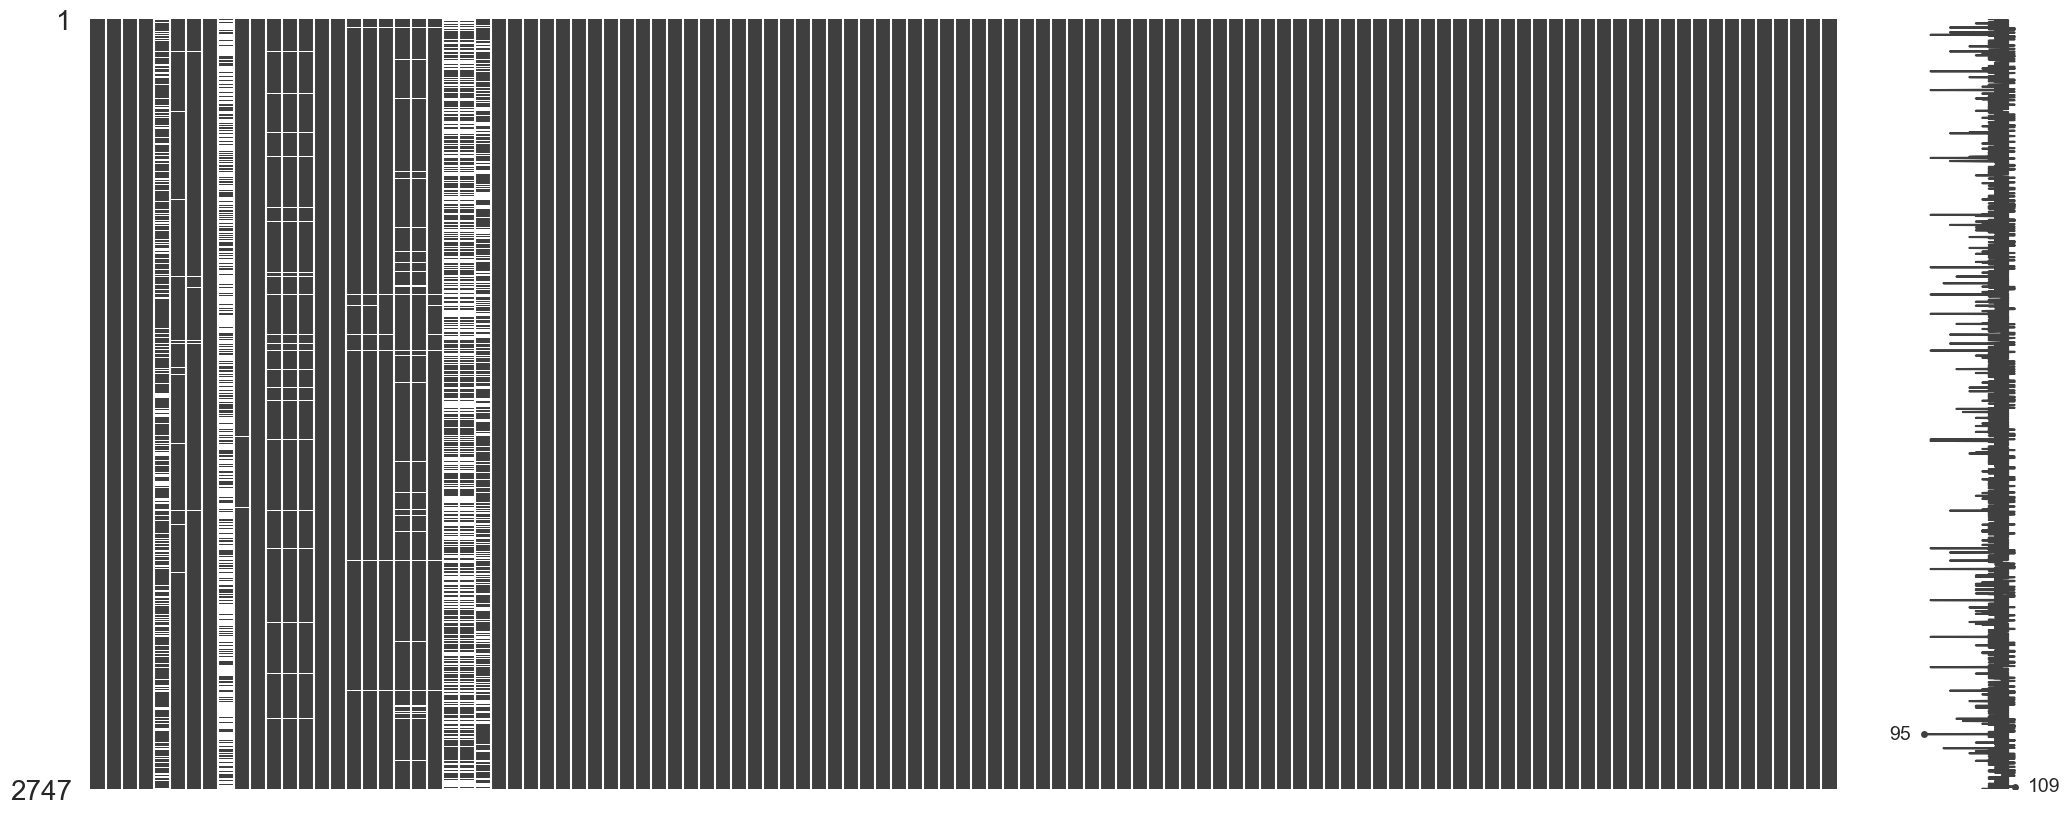

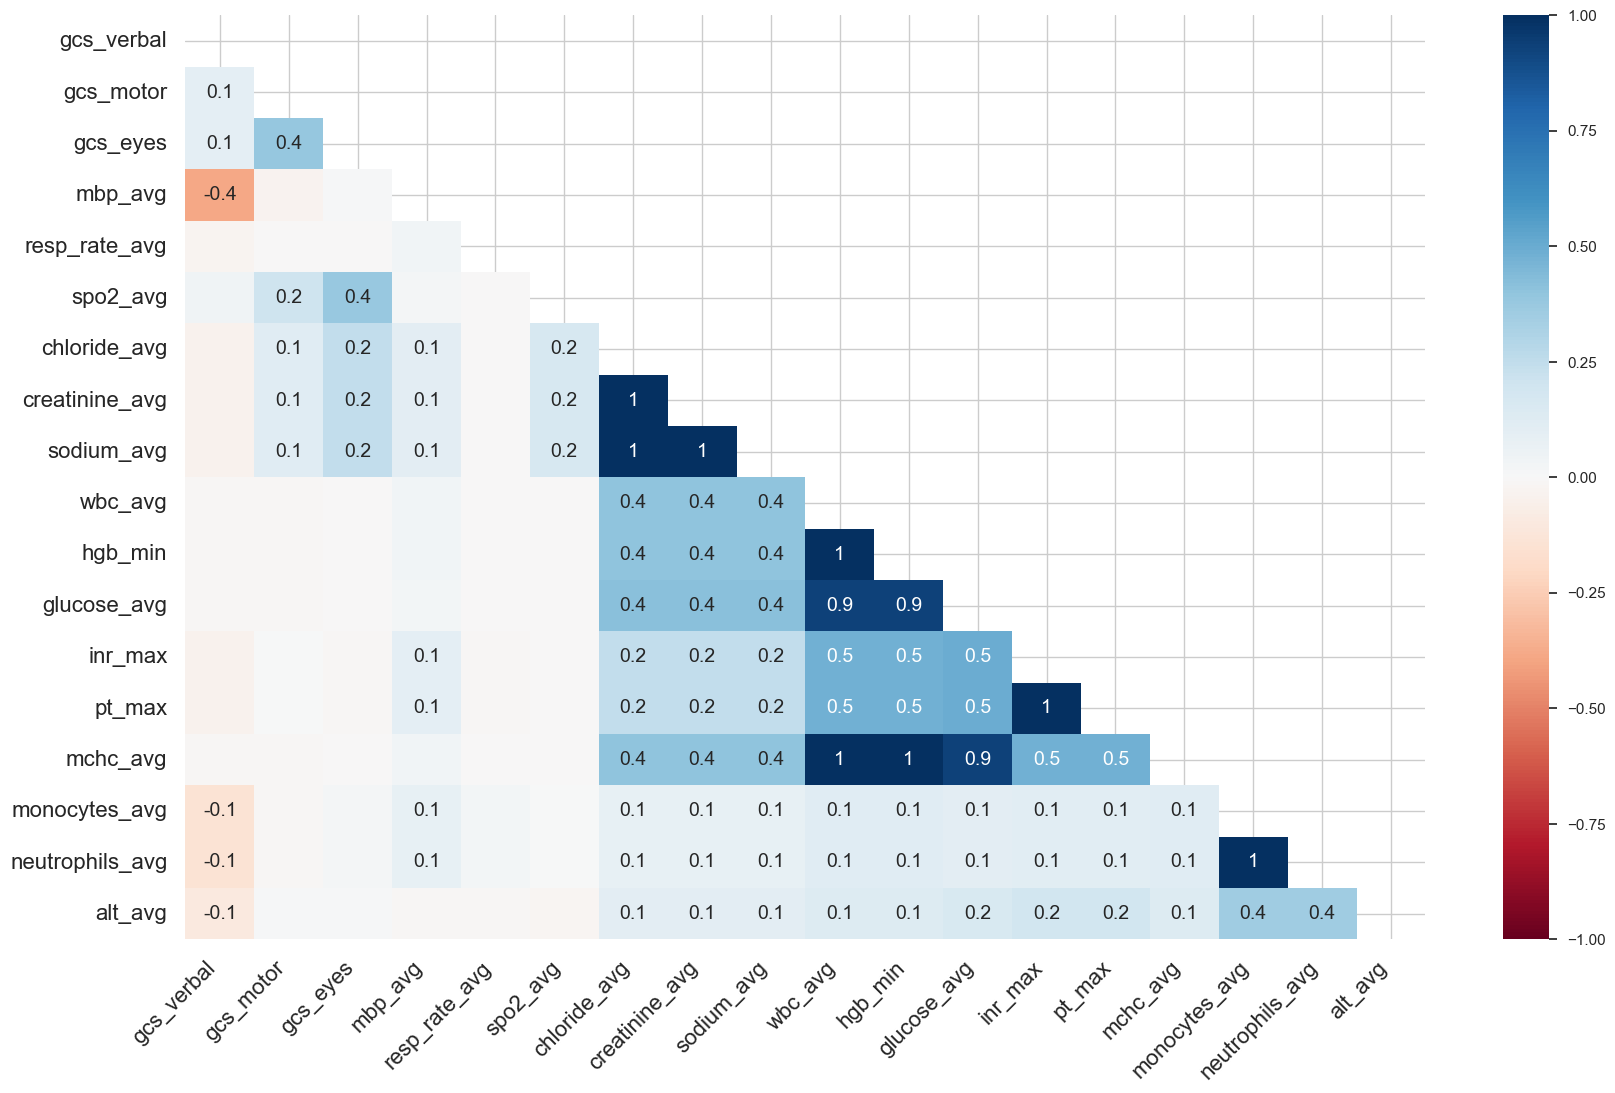

In [163]:
# Visualize missing data patterns

import missingno as msno
msno.matrix(df_clean)  # Busca patrons visuals (ex: columnes amb missings correlacionades)

# Heatmap: correlations of missingness
msno.heatmap(df_clean)

In [164]:
from scipy.stats import chi2_contingency, ttest_ind, ks_2samp

# Loop through numeric variables with missing values
numeric_with_missing = df_clean.select_dtypes(include='number').columns[df_clean.select_dtypes(include='number').isnull().any()]

for col in numeric_with_missing:
    print(f"\n--- Analyzing: {col} ---")
    
    # Create a missingness flag: 1 if missing, 0 if not
    missing_flag = df_clean[col].isnull().astype(int)
    
    # Get readmitted groups
    readmitted_missing = df_clean.loc[missing_flag == 1, 'readmitted'].dropna()
    readmitted_nonmissing = df_clean.loc[missing_flag == 0, 'readmitted'].dropna()
    
    # -- Chi-squared Test
    contingency = pd.crosstab(missing_flag, df_clean['readmitted'])
    if contingency.shape == (2, 2):
        chi2, p_chi, _, _ = chi2_contingency(contingency)
        print(f"Chi-squared p = {p_chi:.4f}", end="  ")
        print("--> " + ("Assoc. detected" if p_chi < 0.05 else "No assoc."))
    
    # -- T-Test
    if len(readmitted_missing) > 10 and len(readmitted_nonmissing) > 10:
        t_stat, p_t = ttest_ind(readmitted_missing, readmitted_nonmissing, equal_var=False)
        print(f"T-test p = {p_t:.4f}", end="  ")
        print("--> " + ("Means differ" if p_t < 0.05 else "No mean diff."))
    
        # -- KS Test
        ks_stat, p_ks = ks_2samp(readmitted_missing, readmitted_nonmissing)
        print(f"KS-test p = {p_ks:.4f}", end="  ")
        print("--> " + ("Distributions differ" if p_ks < 0.05 else "No dist. diff."))


--- Analyzing: gcs_verbal ---
Chi-squared p = 0.0063  --> Assoc. detected
T-test p = 0.0078  --> Means differ
KS-test p = 0.1831  --> No dist. diff.

--- Analyzing: gcs_motor ---
Chi-squared p = 0.2608  --> No assoc.
T-test p = 0.2539  --> No mean diff.
KS-test p = 0.9375  --> No dist. diff.

--- Analyzing: gcs_eyes ---
Chi-squared p = 0.5374  --> No assoc.
T-test p = 0.4389  --> No mean diff.
KS-test p = 0.9964  --> No dist. diff.

--- Analyzing: mbp_avg ---
Chi-squared p = 0.0000  --> Assoc. detected
T-test p = 0.0000  --> Means differ
KS-test p = 0.0025  --> Distributions differ

--- Analyzing: resp_rate_avg ---
Chi-squared p = 1.0000  --> No assoc.

--- Analyzing: spo2_avg ---
Chi-squared p = 0.8161  --> No assoc.

--- Analyzing: chloride_avg ---
Chi-squared p = 0.4327  --> No assoc.
T-test p = 0.3041  --> No mean diff.
KS-test p = 0.9985  --> No dist. diff.

--- Analyzing: creatinine_avg ---
Chi-squared p = 0.4327  --> No assoc.
T-test p = 0.3041  --> No mean diff.
KS-test p = 0.

## Imputación de Valores Faltantes: Estrategia Basada en Análisis MCAR/MAR

Aplicamos diferentes estrategias de imputación según el tipo de ausencia de datos:

- **MCAR (Completamente al Azar)**: No hay evidencia de relación con la variable objetivo (`readmitted`).
- **MAR (Aleatorio Condicional)**: La ausencia muestra cierta correlación con `readmitted`.

Usamos imputación por KNN para tener en cuenta patrones entre variables similares.

Además, para las variables con señales fuertes de MAR/MNAR, añadimos indicadores binarios que marcan si el valor estaba originalmente ausente. Esto permite al modelo capturar información útil sobre la ausencia en sí misma.


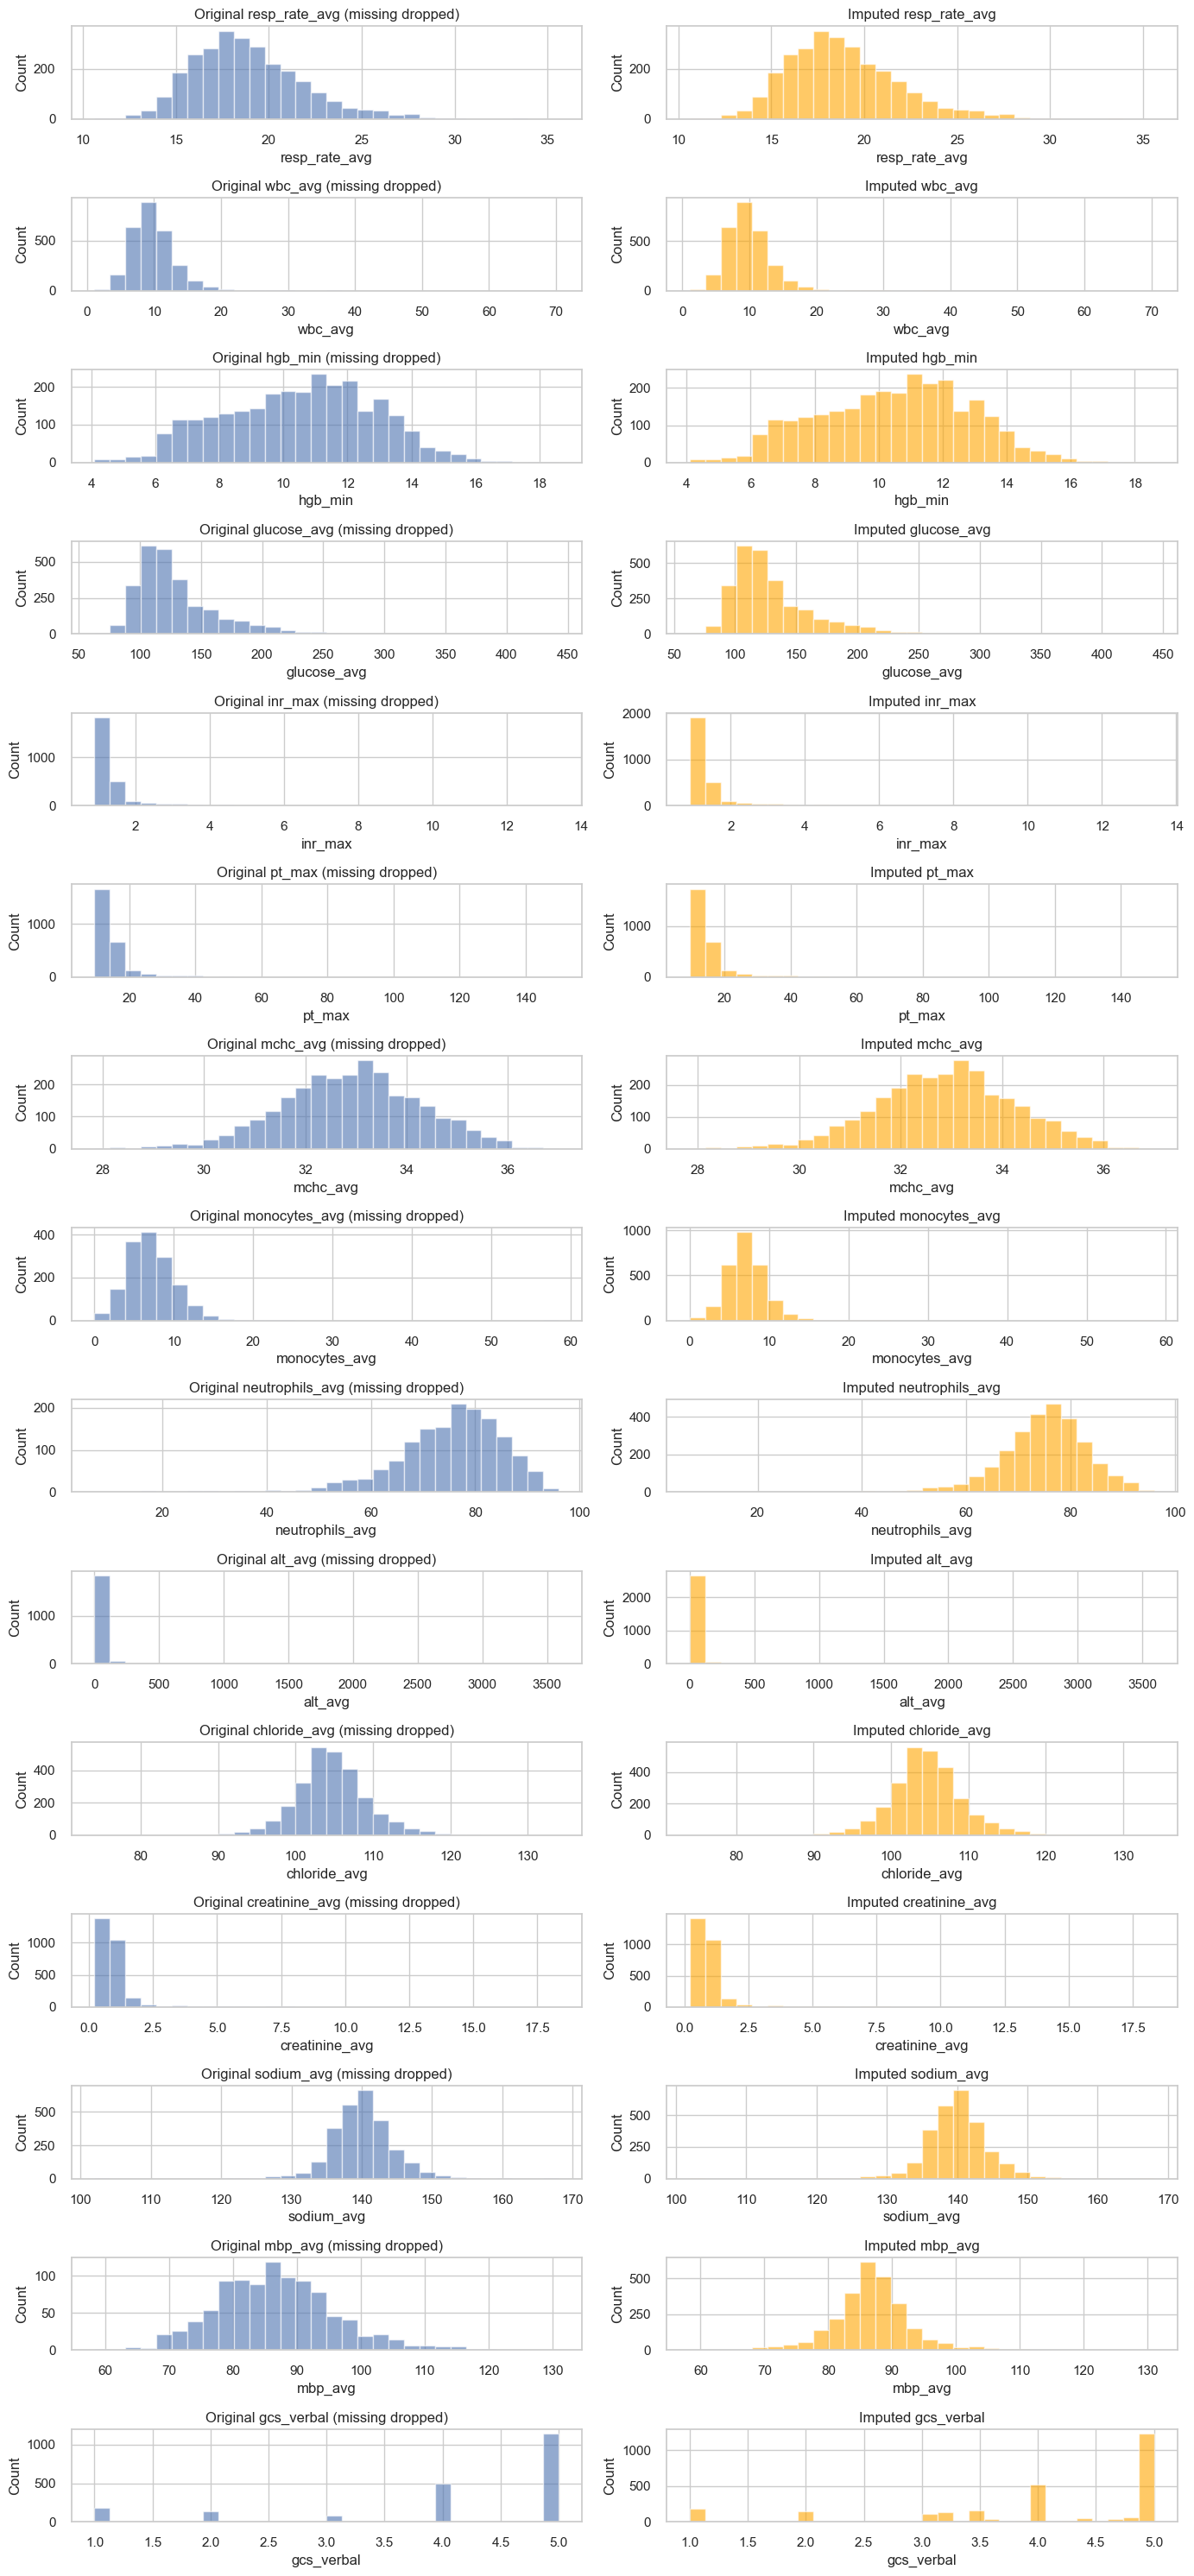

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# --- Step 1: Define variables based on missingness analysis ---
mcar_vars = [
    'resp_rate_avg', 'wbc_avg', 'hgb_min', 'glucose_avg',
    'inr_max', 'pt_max', 'mchc_avg', 'monocytes_avg', 
    'neutrophils_avg', 'alt_avg'
]
weak_mar_vars = ['chloride_avg', 'creatinine_avg', 'sodium_avg']
strong_mar_vars = ['mbp_avg','gcs_verbal']
all_impute_vars = mcar_vars + weak_mar_vars + strong_mar_vars

# --- Step 2: Save a copy of original data (before imputation) ---
df_original = df_clean.copy()

# --- Step 3: Imputation ---

# 3.1 KNN imputation for all variables
knn_imputer = KNNImputer(n_neighbors=5)
df_clean[all_impute_vars] = knn_imputer.fit_transform(df_clean[all_impute_vars])

# 3.2 Add missingness flags for strong MAR variables
for col in strong_mar_vars:
    df_clean[f'{col}_missing'] = df_original[col].isnull().astype(int)

# --- Step 4: Plot original vs imputed histograms ---
plt.figure(figsize=(14, len(all_impute_vars) * 2))

for i, col in enumerate(all_impute_vars):
    # Original data (only non-missing values)
    plt.subplot(len(all_impute_vars), 2, 2 * i + 1)
    plt.hist(df_original[col].dropna(), bins=30, alpha=0.6, label='Original')
    plt.title(f'Original {col} (missing dropped)')
    plt.ylabel('Count')
    plt.xlabel(col)

    # Imputed data (after imputation)
    plt.subplot(len(all_impute_vars), 2, 2 * i + 2)
    plt.hist(df_clean[col], bins=30, alpha=0.6, color='orange', label='Imputed')
    plt.title(f'Imputed {col}')
    plt.ylabel('Count')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


<Axes: >

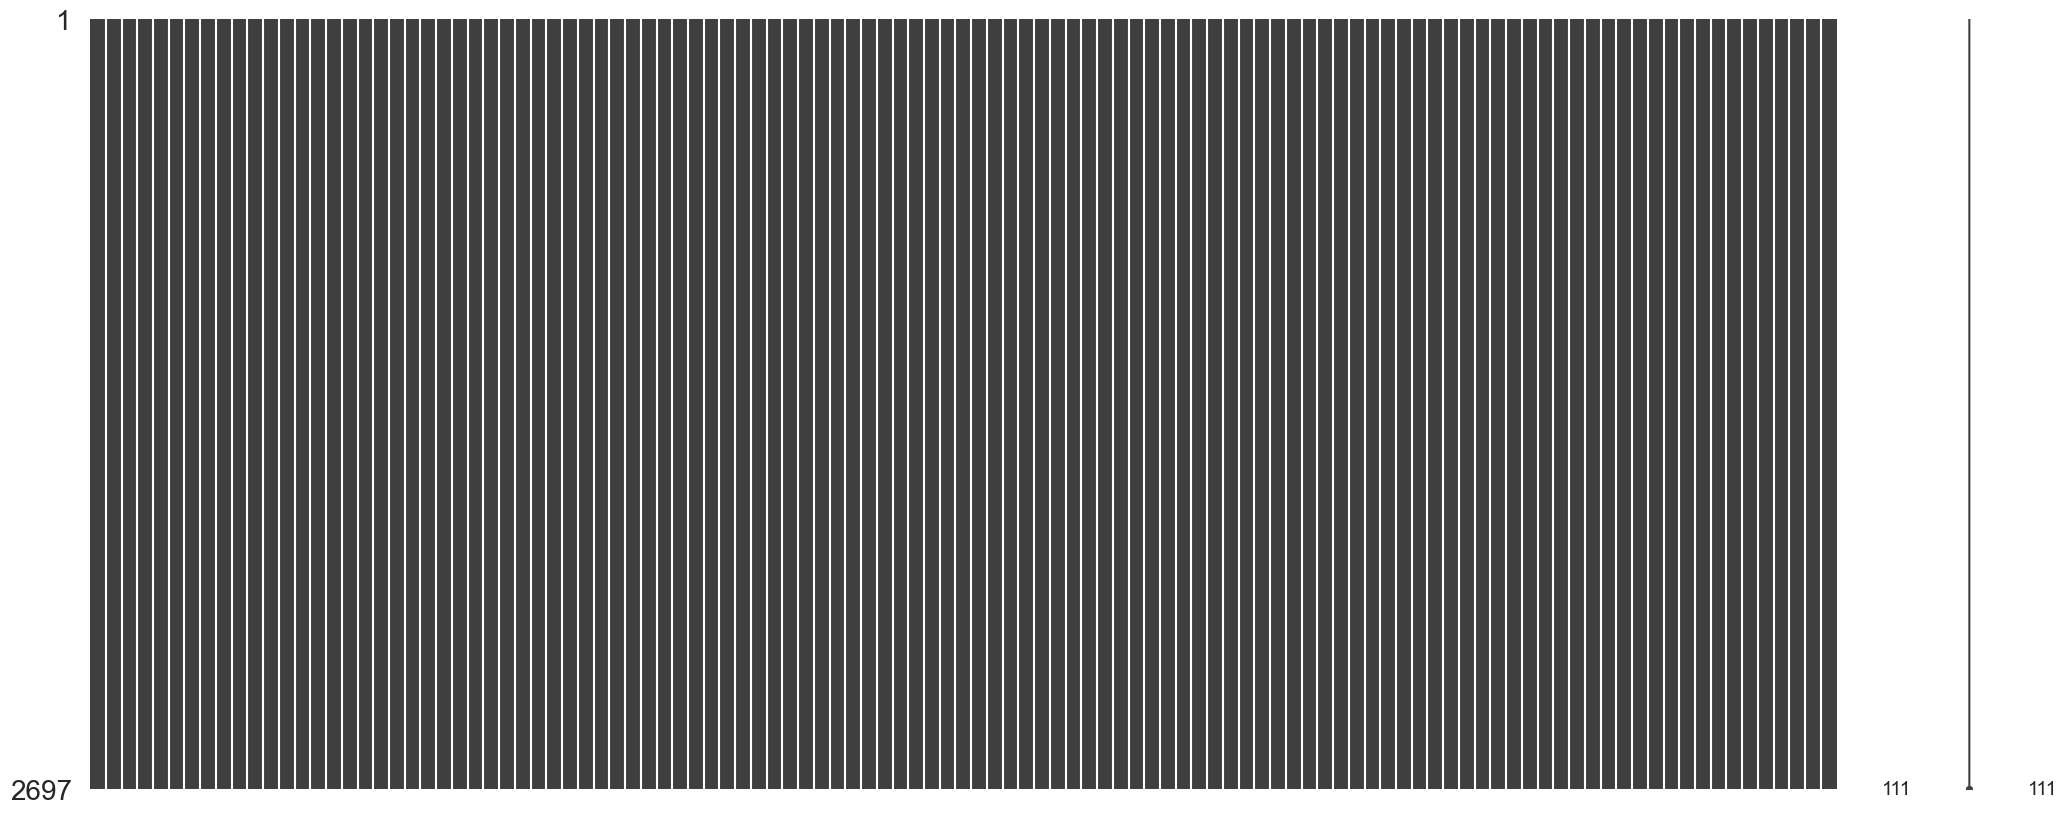

In [166]:
# Visualize missing data patterns

import missingno as msno
df_clean = df_clean.dropna()
msno.matrix(df_clean)  # Busca patrons visuals (ex: columnes amb missings correlacionades)

In [167]:
# Limpiar nombres de columnas antes de pasar a PyCaret
df_clean.columns = (
    df_clean.columns
    .str.strip()
    .str.upper()
    .str.replace('[^A-Z0-9_]', '_', regex=True)  # Reemplaza espacios y símbolos por _
    .str.replace('_+', '_', regex=True)          # Sustituye múltiples _ por uno solo
    .str.strip('_')                              # Elimina guiones bajos sobrantes
)

# Verificar que las columnas existen
assert all(col in df_clean.columns for col in ['GCS_VERBAL', 'GCS_MOTOR', 'GCS_EYES']), "Faltan columnas de GCS"

# Crear la columna total
df_clean['GCS_TOTAL'] = df_clean[['GCS_VERBAL', 'GCS_MOTOR', 'GCS_EYES']].sum(axis=1, min_count=3)

# Drop de las columnas individuales
df_clean = df_clean.drop(columns=['GCS_VERBAL', 'GCS_MOTOR', 'GCS_EYES'])


# Execute Query and Export to CSV
df_clean.to_csv("data/df_clean.csv", index=False)
print("✅ Exported to df_clean.csv")

print(df_clean.dtypes)


df_clean

✅ Exported to df_clean.csv
GENDER                            category
AGE                                  int64
ICU_LOS_HOURS                      float64
HOSP_LOS_HOURS                       int64
HEART_RATE_AVG                     float64
                                    ...   
DISPO_REHAB                          int64
DISPO_SKILLED_NURSING_FACILITY       int64
MBP_AVG_MISSING                      int64
GCS_VERBAL_MISSING                   int64
GCS_TOTAL                          float64
Length: 109, dtype: object


,GENDER,AGE,ICU_LOS_HOURS,HOSP_LOS_HOURS,HEART_RATE_AVG,MBP_AVG,RESP_RATE_AVG,SPO2_AVG,CHLORIDE_AVG,CREATININE_AVG,...,DISPO_HEALTHCARE_FACILITY,DISPO_HOME,DISPO_HOME_HEALTH_CARE,DISPO_HOSPICE,DISPO_OTHER_FACILITY,DISPO_REHAB,DISPO_SKILLED_NURSING_FACILITY,MBP_AVG_MISSING,GCS_VERBAL_MISSING,GCS_TOTAL
0,F,36,320.0,321,79.743590,86.444444,17.565916,98.090032,104.625000,0.562500,...,0,1,0,0,0,0,0,0,1,7.0
1,M,87,123.0,124,118.038168,79.200000,23.454545,94.748092,112.666667,1.550000,...,0,0,0,1,0,0,0,0,1,9.2
2,M,38,383.0,501,67.691099,105.577922,19.811671,97.515873,103.052632,1.326316,...,0,0,0,0,0,1,0,0,1,9.4
3,M,61,103.0,103,78.611111,92.766653,19.600000,96.698630,103.333333,0.700000,...,0,0,1,0,0,0,0,1,0,12.0
4,M,65,35.0,135,65.857143,87.458665,18.428571,94.714286,104.000000,0.900000,...,0,1,0,0,0,0,0,1,0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,F,43,587.0,681,100.142857,97.125899,19.270408,97.904600,103.202899,0.511111,...,0,0,0,0,0,1,0,0,1,12.4
3613,M,74,32.0,82,85.000000,89.523637,19.303030,96.575758,102.333333,0.933333,...,0,0,0,0,0,1,0,1,1,10.4
3614,F,78,66.0,67,61.510638,82.858920,25.260000,96.063830,108.500000,1.150000,...,0,0,0,0,0,0,1,1,0,10.0
3617,M,83,85.0,158,67.435294,88.042051,16.161290,96.093023,104.750000,1.150000,...,0,0,0,0,0,1,0,1,1,12.0


✅ Archivo cargado: 2697 filas, 109 columnas


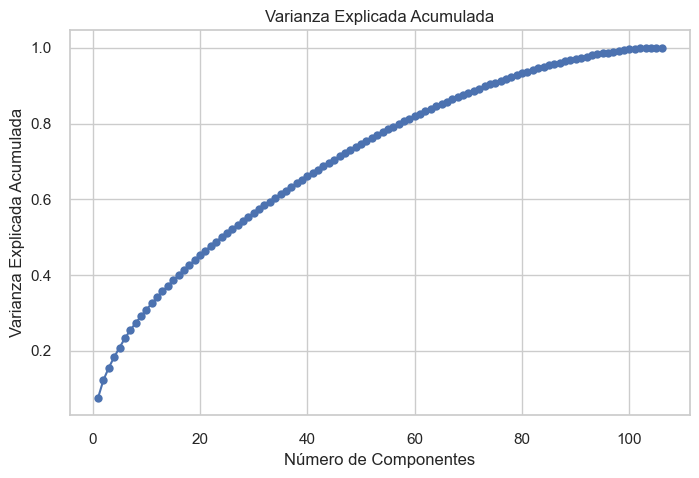

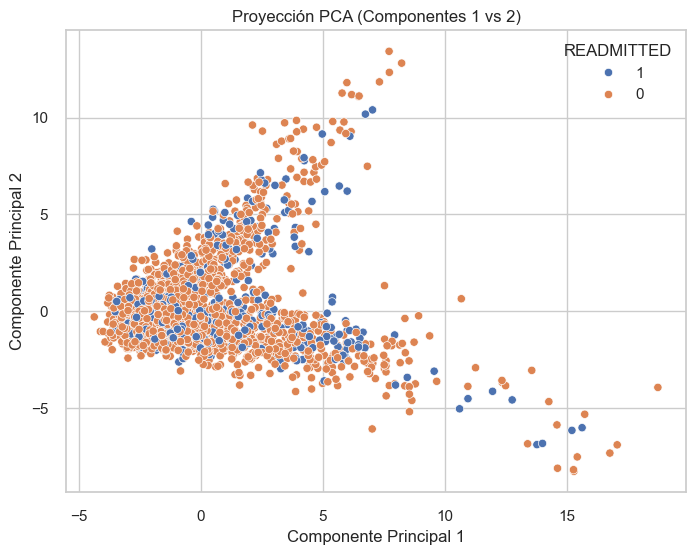

In [192]:
from pycaret.classification import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df= pd.read_csv("data/df_clean.csv")
print(f"✅ Archivo cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

df = df.drop(columns=['READMITTED_TO_HOSPITAL'], errors='ignore')  # errors='ignore' por si ya no existe

# Análisis PCA
def perform_pca(df, target_col='READMITTED'):
    # 1. Seleccionar solo columnas numéricas
    numeric_df = df.select_dtypes(include='number').drop(columns=[target_col], errors='ignore').dropna()

    # 2. Estandarización
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(numeric_df)

    # 3. PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # 4. Scree plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             pca.explained_variance_ratio_.cumsum(), marker='o')
    plt.title('Varianza Explicada Acumulada')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza Explicada Acumulada')
    plt.grid(True)
    plt.show()

    # 5. PCA 2D plot
    if target_col in df.columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df[target_col].astype(str))
        plt.title('Proyección PCA (Componentes 1 vs 2)')
        plt.xlabel('Componente Principal 1')
        plt.ylabel('Componente Principal 2')
        plt.legend(title=target_col)
        plt.show()
    
    return pca

# Ejecución
pca_model = perform_pca(df)

### 4. 📊 Modelado Predictivo

#### Modelos Utilizados
- `Extra Trees Classifier`
- Técnicas de balanceo como `RandomOverSampler`

#### Evaluación del Desempeño
- Se define un entorno tipo *playground* para probar múltiples combinaciones de variables y modelos.
- Se hace énfasis en interpretar las variables predictoras más influyentes.

In [173]:
from pycaret.classification import *
import pandas as pd
import numpy as np

df= pd.read_csv("data/df_clean.csv")
print(f"✅ Archivo cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

✅ Archivo cargado: 2697 filas, 109 columnas


## PLAYGROUND: PLUG AND PLAY WITH YOUR FAVOURITE VARIABLES

In [169]:
from pycaret.classification import setup, compare_models

# 📌 Lista de features seleccionadas manualmente
manual_features = [
    'MBP_AVG',
    'SPO2_AVG',
    'AGE',
    'HGB_MIN',
    'HOSP_LOS_HOURS',
    'GCS_TOTAL',
]

# Incluye la nueva variable target
selected_columns = manual_features + ['READMITTED_TO_HOSPITAL']
df_selected = df[selected_columns]

# Configurar PyCaret
exp = setup(
    data=df_selected,
    target='READMITTED_TO_HOSPITAL',
    session_id=123,
    normalize=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
)

# Comparar modelos
print("\nComparing models... please wait, this may take a few minutes...")
best_model = compare_models()



,Description,Value
0,Session id,123
1,Target,READMITTED_TO_HOSPITAL
2,Target type,Binary
3,Original data shape,"(2697, 7)"
4,Transformed data shape,"(2697, 7)"
5,Transformed train set shape,"(1887, 7)"
6,Transformed test set shape,"(810, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple



Comparing models... please wait, this may take a few minutes...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6306,0.6260,0.2787,0.5129,0.3598,0.1321,0.1444,0.0520
dummy,Dummy Classifier,0.6253,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0090
rf,Random Forest Classifier,0.6232,0.6237,0.2602,0.4977,0.3406,0.1116,0.1239,0.0750
gbc,Gradient Boosting Classifier,0.6216,0.6038,0.2037,0.4898,0.2864,0.0857,0.1014,0.0580
ridge,Ridge Classifier,0.6206,0.5834,0.0594,0.4474,0.1030,0.0194,0.0339,0.0060
lr,Logistic Regression,0.6190,0.5833,0.0679,0.4255,0.1151,0.0201,0.0301,0.3230
ada,Ada Boost Classifier,0.6190,0.5767,0.1923,0.4766,0.2725,0.0757,0.0896,0.0280
lda,Linear Discriminant Analysis,0.6190,0.5834,0.0693,0.4264,0.1173,0.0208,0.0310,0.0070
lightgbm,Light Gradient Boosting Machine,0.6174,0.6109,0.3466,0.4885,0.4044,0.1343,0.1393,0.2300
qda,Quadratic Discriminant Analysis,0.6100,0.5689,0.1445,0.4348,0.2147,0.0383,0.0478,0.0060


In [170]:
df = df.drop(columns=['READMITTED'], errors='ignore')  # errors='ignore' por si ya no existe

exp = setup(
    data=df,
    target='READMITTED_TO_HOSPITAL',
    session_id=123,
    normalize=True,
    remove_multicollinearity=True,
    fix_imbalance=True,
    multicollinearity_threshold=0.95,
)

print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model = compare_models()

,Description,Value
0,Session id,123
1,Target,READMITTED_TO_HOSPITAL
2,Target type,Binary
3,Original data shape,"(2697, 108)"
4,Transformed data shape,"(3170, 108)"
5,Transformed train set shape,"(2360, 108)"
6,Transformed test set shape,"(810, 108)"
7,Numeric features,106
8,Categorical features,1
9,Preprocess,True



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7027,0.7351,0.4399,0.6551,0.5243,0.3208,0.3351,0.0920
rf,Random Forest Classifier,0.6979,0.7070,0.4044,0.6565,0.4991,0.3009,0.3193,0.1130
lightgbm,Light Gradient Boosting Machine,0.6863,0.7065,0.4638,0.6084,0.5258,0.2976,0.3042,0.2990
gbc,Gradient Boosting Classifier,0.6751,0.6919,0.4568,0.5885,0.5136,0.2753,0.2809,0.2660
ada,Ada Boost Classifier,0.6348,0.6512,0.4651,0.5170,0.4885,0.2060,0.2074,0.0790
dummy,Dummy Classifier,0.6253,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0440
lr,Logistic Regression,0.6216,0.6646,0.5938,0.4972,0.5404,0.2236,0.2263,0.0690
ridge,Ridge Classifier,0.6157,0.6619,0.5910,0.4909,0.5354,0.2131,0.2161,0.0290
lda,Linear Discriminant Analysis,0.6157,0.6618,0.5910,0.4909,0.5354,0.2131,0.2161,0.0460
dt,Decision Tree Classifier,0.6100,0.5816,0.4683,0.4788,0.4731,0.1638,0.1639,0.0420


In [174]:
exp = setup(
    data=df,
    target='READMITTED',
    session_id=123,
    normalize=True,  # solo si incluirás modelos que lo requieren
    #feature_selection=True,  # <-- activa selección de variables
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
)

# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model = compare_models()

df

,Description,Value
0,Session id,123
1,Target,READMITTED
2,Target type,Binary
3,Original data shape,"(2697, 109)"
4,Transformed data shape,"(2697, 109)"
5,Transformed train set shape,"(1887, 109)"
6,Transformed test set shape,"(810, 109)"
7,Numeric features,107
8,Categorical features,1
9,Preprocess,True



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8505,0.9164,0.3780,0.6798,0.4824,0.4034,0.4289,0.0910
ridge,Ridge Classifier,0.8400,0.9012,0.5131,0.5773,0.5399,0.4441,0.4471,0.0360
rf,Random Forest Classifier,0.8373,0.9080,0.2091,0.7055,0.3170,0.2563,0.3182,0.1100
gbc,Gradient Boosting Classifier,0.8352,0.9034,0.4788,0.5664,0.5169,0.4189,0.4221,0.1670
lightgbm,Light Gradient Boosting Machine,0.8352,0.9013,0.5414,0.5628,0.5504,0.4498,0.4508,0.2820
lr,Logistic Regression,0.8336,0.9003,0.5387,0.5528,0.5423,0.4413,0.4433,0.0570
svm,SVM - Linear Kernel,0.8310,0.8979,0.5015,0.5646,0.5239,0.4228,0.4280,0.0240
dt,Decision Tree Classifier,0.8309,0.7192,0.5418,0.5510,0.5415,0.4388,0.4416,0.0340
knn,K Neighbors Classifier,0.8246,0.7039,0.1870,0.5745,0.2723,0.2056,0.2490,0.0270
ada,Ada Boost Classifier,0.8204,0.8864,0.5073,0.5208,0.5116,0.4020,0.4035,0.0920


,GENDER,AGE,ICU_LOS_HOURS,HOSP_LOS_HOURS,HEART_RATE_AVG,MBP_AVG,RESP_RATE_AVG,SPO2_AVG,CHLORIDE_AVG,CREATININE_AVG,...,DISPO_HEALTHCARE_FACILITY,DISPO_HOME,DISPO_HOME_HEALTH_CARE,DISPO_HOSPICE,DISPO_OTHER_FACILITY,DISPO_REHAB,DISPO_SKILLED_NURSING_FACILITY,MBP_AVG_MISSING,GCS_VERBAL_MISSING,GCS_TOTAL
0,F,36,320.0,321,79.743590,86.444444,17.565916,98.090032,104.625000,0.562500,...,0,1,0,0,0,0,0,0,1,7.0
1,M,87,123.0,124,118.038168,79.200000,23.454545,94.748092,112.666667,1.550000,...,0,0,0,1,0,0,0,0,1,9.2
2,M,38,383.0,501,67.691099,105.577922,19.811671,97.515873,103.052632,1.326316,...,0,0,0,0,0,1,0,0,1,9.4
3,M,61,103.0,103,78.611111,92.766653,19.600000,96.698630,103.333333,0.700000,...,0,0,1,0,0,0,0,1,0,12.0
4,M,65,35.0,135,65.857143,87.458665,18.428571,94.714286,104.000000,0.900000,...,0,1,0,0,0,0,0,1,0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,F,43,587.0,681,100.142857,97.125899,19.270408,97.904600,103.202899,0.511111,...,0,0,0,0,0,1,0,0,1,12.4
2693,M,74,32.0,82,85.000000,89.523637,19.303030,96.575758,102.333333,0.933333,...,0,0,0,0,0,1,0,1,1,10.4
2694,F,78,66.0,67,61.510638,82.858920,25.260000,96.063830,108.500000,1.150000,...,0,0,0,0,0,0,1,1,0,10.0
2695,M,83,85.0,158,67.435294,88.042051,16.161290,96.093023,104.750000,1.150000,...,0,0,0,0,0,1,0,1,1,12.0


In [175]:
et_model = create_model('et')
evaluate_model(et_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8624,0.9303,0.4286,0.7143,0.5357,0.4608,0.4816
1,0.8307,0.8946,0.3429,0.5714,0.4286,0.3364,0.3515
2,0.8360,0.9032,0.4000,0.5833,0.4746,0.3814,0.3909
3,0.8624,0.9521,0.4000,0.7368,0.5185,0.4464,0.4748
4,0.8730,0.9267,0.4286,0.7895,0.5556,0.4890,0.5201
5,0.8413,0.8690,0.2857,0.6667,0.4000,0.3250,0.3639
6,0.8624,0.9320,0.3143,0.8462,0.4583,0.3979,0.4624
7,0.8085,0.8878,0.2941,0.4545,0.3571,0.2507,0.2589
8,0.8298,0.9076,0.3429,0.5714,0.4286,0.3358,0.3510


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [176]:
tuned_model = tune_model(et_model, optimize='Prec.')  # or accuracy, recall, etc.

evaluate_model(tuned_model)

from pycaret.classification import predict_model
import pandas as pd
from pycaret.classification import get_config

# Retrieve the X_test and y_test used internally by PyCaret
X_test_manual = get_config("X_test").copy()
y_test = get_config("y_test").copy()


# 1️⃣ Predict on the test set
predictions = predict_model(tuned_model, data=X_test_manual, raw_score=True)

print(predictions.columns)

# 2️⃣ Extract predicted probabilities and classes
y_proba = predictions['prediction_score_1']  # assuming binary classification, and '1' is the positive class
y_pred = predictions['prediction_label']

# 3️⃣ Define risk bands
def risk_band(p):
    if p > 0.5:
        return "High Risk"
    elif p >= 0.3:
        return "Medium Risk"
    else:
        return "Low Risk"

risk_labels = [risk_band(p) for p in y_proba]

# 4️⃣ Attach everything to test set
X_test_with_risk = X_test_manual.copy()
X_test_with_risk["Probability"] = y_proba
X_test_with_risk["Predicted_Label"] = y_pred
X_test_with_risk["Risk_Band"] = risk_labels

# 5️⃣ Summary statistics
print("📊 Risk Band Summary:")
print(X_test_with_risk["Risk_Band"].value_counts())

high_risk_patients = X_test_with_risk[X_test_with_risk["Risk_Band"] == "High Risk"]
print(f"\n📬 High Risk Patients to Alert: {len(high_risk_patients)}")

expected_readmissions = y_proba.sum()
print(f"🏥 Estimated total readmissions (probability sum): {expected_readmissions:.2f} out of {len(y_proba)}")

# Optional: save to file
# X_test_with_risk.to_csv("predicted_patients_with_risk_bands.csv", index=False)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8042,0.9027,0.2857,0.4545,0.3509,0.2426,0.2517
1,0.7989,0.8685,0.2000,0.4118,0.2692,0.1686,0.1834
2,0.8307,0.8814,0.4857,0.5484,0.5152,0.4130,0.4142
3,0.8413,0.9186,0.4571,0.5926,0.5161,0.4231,0.4282
4,0.8413,0.9141,0.2286,0.7273,0.3478,0.2845,0.3469
5,0.8201,0.8606,0.6286,0.5116,0.5641,0.4523,0.4561
6,0.8254,0.9108,0.2000,0.5833,0.2979,0.2245,0.2669
7,0.7979,0.8835,0.2059,0.3889,0.2692,0.1646,0.1759
8,0.8138,0.8730,0.3143,0.5000,0.3860,0.2829,0.2935


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Index(['GENDER', 'AGE', 'ICU_LOS_HOURS', 'HOSP_LOS_HOURS', 'HEART_RATE_AVG',
       'MBP_AVG', 'RESP_RATE_AVG', 'SPO2_AVG', 'CHLORIDE_AVG',
       'CREATININE_AVG',
       ...
       'DISPO_HOSPICE', 'DISPO_OTHER_FACILITY', 'DISPO_REHAB',
       'DISPO_SKILLED_NURSING_FACILITY', 'MBP_AVG_MISSING',
       'GCS_VERBAL_MISSING', 'GCS_TOTAL', 'prediction_label',
       'prediction_score_0', 'prediction_score_1'],
      dtype='object', length=111)
📊 Risk Band Summary:
Risk_Band
Low Risk       559
Medium Risk    150
High Risk      101
Name: count, dtype: int64

📬 High Risk Patients to Alert: 101
🏥 Estimated total readmissions (probability sum): 152.41 out of 810


In [177]:
rf_model = create_model('rf')
evaluate_model(rf_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8624,0.9278,0.3143,0.8462,0.4583,0.3979,0.4624
1,0.8307,0.8768,0.2286,0.6154,0.3333,0.2590,0.3010
2,0.8360,0.8959,0.2286,0.6667,0.3404,0.2715,0.3227
3,0.8413,0.9294,0.2000,0.7778,0.3182,0.2623,0.3411
4,0.8413,0.9134,0.2286,0.7273,0.3478,0.2845,0.3469
5,0.8413,0.8841,0.1714,0.8571,0.2857,0.2387,0.3393
6,0.8201,0.9186,0.0571,0.6667,0.1053,0.0783,0.1574
7,0.8245,0.8854,0.1765,0.5455,0.2667,0.1955,0.2362
8,0.8245,0.8870,0.2000,0.5833,0.2979,0.2241,0.2664


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [178]:
from pycaret.classification import *
import pandas as pd
import numpy as np

df= pd.read_csv("data/df_clean.csv")
print(f"✅ Archivo cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

exp = setup(
    data=df,
    target='READMITTED',
    session_id=123,
    normalize=True,  # solo si incluirás modelos que lo requieren
    feature_selection=True,  # <-- activa selección de variables
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
)

# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model_fs = compare_models()

✅ Archivo cargado: 2697 filas, 109 columnas
[LightGBM] [Info] Number of positive: 349, number of negative: 1538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4561
[LightGBM] [Info] Number of data points in the train set: 1887, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184950 -> initscore=-1.483166
[LightGBM] [Info] Start training from score -1.483166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

,Description,Value
0,Session id,123
1,Target,READMITTED
2,Target type,Binary
3,Original data shape,"(2697, 109)"
4,Transformed data shape,"(2697, 22)"
5,Transformed train set shape,"(1887, 22)"
6,Transformed test set shape,"(810, 22)"
7,Numeric features,107
8,Categorical features,1
9,Preprocess,True



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8400,0.8777,0.4671,0.5825,0.5058,0.4161,0.4236,0.3710
lightgbm,Light Gradient Boosting Machine,0.8384,0.8730,0.5039,0.5792,0.5287,0.4339,0.4400,0.4390
rf,Random Forest Classifier,0.8352,0.8679,0.3438,0.5987,0.4249,0.3410,0.3622,0.3130
et,Extra Trees Classifier,0.8331,0.8784,0.4125,0.6116,0.4657,0.3748,0.3927,0.2900
ridge,Ridge Classifier,0.8198,0.8596,0.4191,0.4671,0.4364,0.3400,0.3437,0.2740
lr,Logistic Regression,0.8193,0.8605,0.4305,0.4648,0.4437,0.3459,0.3482,0.3160
dummy,Dummy Classifier,0.8151,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2690
svm,SVM - Linear Kernel,0.8135,0.8420,0.4183,0.4795,0.4428,0.3335,0.3360,0.2390
ada,Ada Boost Classifier,0.8119,0.8525,0.4555,0.4675,0.4566,0.3477,0.3480,0.2950
dt,Decision Tree Classifier,0.8103,0.6865,0.4900,0.4923,0.4895,0.3735,0.3743,0.2570


In [6]:
et_model = create_model('et')
evaluate_model(et_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8166,0.6418,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8284,0.6654,0.0645,1.0000,0.1212,0.1012,0.2309
2,0.8107,0.6511,0.0312,0.5000,0.0588,0.0374,0.0868
3,0.8107,0.5885,0.0312,0.5000,0.0588,0.0374,0.0868
4,0.8225,0.7319,0.0625,1.0000,0.1176,0.0975,0.2264
5,0.8274,0.6675,0.0645,1.0000,0.1212,0.1011,0.2307
6,0.8274,0.6895,0.0645,1.0000,0.1212,0.1011,0.2307
7,0.8214,0.6817,0.0323,1.0000,0.0625,0.0516,0.1627
8,0.8274,0.6389,0.0645,1.0000,0.1212,0.1011,0.2307


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [7]:
exp_smote = setup(
    data=df,
    target='READMITTED',
    session_id=123,
    normalize=True,
    #feature_selection=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    fix_imbalance=True,  # 🔥 esto activa balanceo de clases
    fix_imbalance_method='smote',  # (opcional) puedes usar otras como 'adasyn'
)

# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model_smote = compare_models()

,Description,Value
0,Session id,123
1,Target,READMITTED
2,Target type,Binary
3,Original data shape,"(2408, 108)"
4,Transformed data shape,"(3467, 108)"
5,Transformed train set shape,"(2744, 108)"
6,Transformed test set shape,"(723, 108)"
7,Numeric features,106
8,Categorical features,1
9,Preprocess,True



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8291,0.6439,0.1178,0.7313,0.1987,0.1589,0.2427,0.0910
et,Extra Trees Classifier,0.8285,0.6560,0.1340,0.6796,0.2222,0.1741,0.2475,0.0690
gbc,Gradient Boosting Classifier,0.8154,0.6244,0.1117,0.5187,0.1830,0.1254,0.1738,0.3010
lightgbm,Light Gradient Boosting Machine,0.8148,0.6305,0.1468,0.5376,0.2272,0.1574,0.2031,0.2950
dummy,Dummy Classifier,0.8142,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0290
ada,Ada Boost Classifier,0.7816,0.6039,0.1402,0.3049,0.1888,0.0846,0.0936,0.0890
dt,Decision Tree Classifier,0.7081,0.5431,0.2808,0.2469,0.2602,0.0810,0.0818,0.0380
lr,Logistic Regression,0.6060,0.6160,0.4950,0.2367,0.3196,0.0905,0.1016,0.0410
lda,Linear Discriminant Analysis,0.6000,0.6150,0.5173,0.2374,0.3249,0.0942,0.1084,0.0350
ridge,Ridge Classifier,0.5994,0.6150,0.5173,0.2371,0.3246,0.0937,0.1078,0.0320


In [ ]:
et_model = create_model('et')
evaluate_model(et_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8047,0.6421,0.1562,0.4545,0.2326,0.1502,0.1786
1,0.8343,0.7118,0.1875,0.7500,0.3000,0.2426,0.3190
2,0.8402,0.7351,0.2500,0.7273,0.3721,0.3047,0.3623
3,0.8155,0.6923,0.0645,0.5000,0.1143,0.0753,0.1270
4,0.8095,0.5798,0.0968,0.4286,0.1579,0.0965,0.1312
5,0.8452,0.6664,0.1613,1.0000,0.2778,0.2388,0.3682
6,0.8214,0.6463,0.0968,0.6000,0.1667,0.1216,0.1876
7,0.8333,0.6528,0.1613,0.7143,0.2632,0.2094,0.2848
8,0.8452,0.6648,0.1935,0.8571,0.3158,0.2659,0.3616


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [26]:
exp_smote = setup(
    data=df,
    target='READMITTED',
    session_id=123,
    normalize=True,
    feature_selection=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    fix_imbalance=True,  # 🔥 esto activa balanceo de clases
    fix_imbalance_method='smote',  # (opcional) puedes usar otras como 'adasyn'
)

# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model_smote_fs = compare_models()

,Description,Value
0,Session id,123
1,Target,READMITTED
2,Target type,Binary
3,Original data shape,"(2405, 109)"
4,Transformed data shape,"(3460, 22)"
5,Transformed train set shape,"(2738, 22)"
6,Transformed test set shape,"(722, 22)"
7,Numeric features,107
8,Categorical features,1
9,Preprocess,True



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.8134,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3230
et,Extra Trees Classifier,0.7843,0.6386,0.1686,0.3509,0.2240,0.1166,0.1289,0.3170
lightgbm,Light Gradient Boosting Machine,0.7611,0.5918,0.1749,0.2824,0.2140,0.0830,0.0870,0.4980
rf,Random Forest Classifier,0.7582,0.6224,0.1876,0.2892,0.2265,0.0903,0.0942,0.3980
gbc,Gradient Boosting Classifier,0.6958,0.5880,0.3058,0.2469,0.2717,0.0833,0.0844,0.4980
dt,Decision Tree Classifier,0.6851,0.5451,0.3218,0.2410,0.2747,0.0793,0.0810,0.3000
ada,Ada Boost Classifier,0.6572,0.5975,0.4080,0.2526,0.3088,0.1009,0.1062,0.3410
lr,Logistic Regression,0.5858,0.5980,0.4967,0.2229,0.3066,0.0683,0.0813,0.3140
ridge,Ridge Classifier,0.5852,0.6016,0.4998,0.2239,0.3081,0.0697,0.0828,0.3140
lda,Linear Discriminant Analysis,0.5852,0.6016,0.4998,0.2239,0.3081,0.0697,0.0828,0.3040


In [29]:
tuned_model = tune_model(best_model_fs, optimize='F1')  # or accuracy, recall, etc.

evaluate_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7633,0.6095,0.1562,0.2778,0.2000,0.0737,0.0779
1,0.6627,0.6610,0.6875,0.3188,0.4356,0.2387,0.2745
2,0.5917,0.6884,0.7188,0.2771,0.4000,0.1743,0.2201
3,0.5952,0.6426,0.5806,0.2466,0.3462,0.1176,0.1402
4,0.5774,0.5599,0.5161,0.2222,0.3107,0.0710,0.0842
5,0.5893,0.6706,0.6774,0.2625,0.3784,0.1531,0.1917
6,0.5655,0.6002,0.6452,0.2439,0.3540,0.1177,0.1495
7,0.7024,0.6237,0.3548,0.2683,0.3056,0.1208,0.1227
8,0.5655,0.6901,0.7742,0.2667,0.3967,0.1684,0.2275


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Randomoversampler 

In [81]:
exp_random = setup(
    data=df_clean,
    target='READMITTED',
    session_id=123,
    normalize=True,
    feature_selection=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    fix_imbalance=True,  # 🔥 esto activa balanceo de clases
    fix_imbalance_method='randomoversampler',  # (opcional) 
)

# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model_random = compare_models()

,Description,Value
0,Session id,123
1,Target,READMITTED
2,Target type,Binary
3,Original data shape,"(2405, 109)"
4,Transformed data shape,"(3460, 22)"
5,Transformed train set shape,"(2738, 22)"
6,Transformed test set shape,"(722, 22)"
7,Numeric features,107
8,Categorical features,1
9,Preprocess,True



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8206,0.6652,0.0414,0.8500,0.0786,0.0641,0.1651,0.3690
rf,Random Forest Classifier,0.8170,0.6392,0.0733,0.6556,0.1300,0.0923,0.1685,0.3520
dummy,Dummy Classifier,0.8134,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2810
lightgbm,Light Gradient Boosting Machine,0.7808,0.5962,0.1240,0.2970,0.1729,0.0709,0.0808,0.5000
dt,Decision Tree Classifier,0.7041,0.5322,0.2579,0.2361,0.2455,0.0628,0.0630,0.3010
gbc,Gradient Boosting Classifier,0.6887,0.6013,0.3024,0.2374,0.2650,0.0717,0.0729,0.4160
knn,K Neighbors Classifier,0.6215,0.5824,0.4389,0.2283,0.2997,0.0740,0.0824,0.3090
qda,Quadratic Discriminant Analysis,0.6081,0.5507,0.4446,0.2290,0.2935,0.0697,0.0736,0.2800
nb,Naive Bayes,0.6079,0.5841,0.4636,0.2271,0.3015,0.0726,0.0843,0.2810
ada,Ada Boost Classifier,0.6067,0.5922,0.4682,0.2301,0.3078,0.0770,0.0862,0.3130


In [ ]:
evaluate_model(best_model_random)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Extra Tree Classifier 

In [186]:
df= pd.read_csv("data/df_clean.csv")
print(f"✅ Archivo cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

# Drop target columns first
X = df.drop(columns=['READMITTED', 'READMITTED_TO_HOSPITAL'], errors='ignore')

# Drop all columns that start with 'DISPO'
dispo_cols = [col for col in X.columns if col.upper().startswith('DISPO')]
X = X.drop(columns=dispo_cols)
y = df['READMITTED'].astype(int)  # Convertir a int si es necesario

# Encode categorical variables
X = pd.get_dummies(X)

# Continue with train/test split and modeling

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_train, y_train)

# Plot feature importances as before...

✅ Archivo cargado: 2697 filas, 109 columnas


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

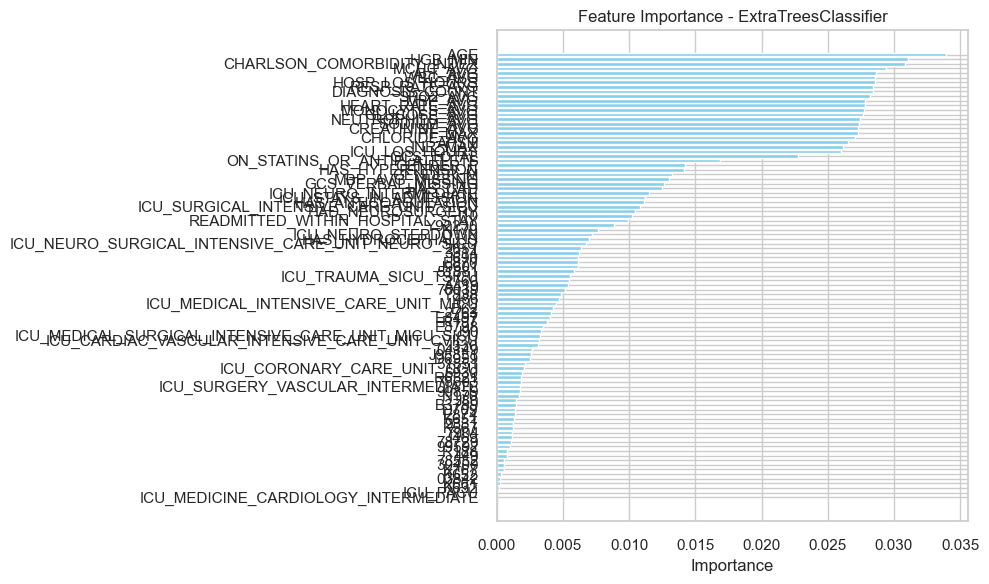

In [187]:
import matplotlib.pyplot as plt
import pandas as pd

importances = model.feature_importances_
features = X_train.columns

feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance - ExtraTreesClassifier')
plt.tight_layout()
plt.show()


                       Feature  Importance
0                          AGE    0.033914
13                     HGB_MIN    0.031103
10  CHARLSON_COMORBIDITY_INDEX    0.030855
17                    MCHC_AVG    0.029401
20                     ALT_AVG    0.028624
12                     WBC_AVG    0.028557
2               HOSP_LOS_HOURS    0.028538
5                RESP_RATE_AVG    0.028433
29             DIAGNOSIS_COUNT    0.028404
6                     SPO2_AVG    0.028225
4                      MBP_AVG    0.027854
3               HEART_RATE_AVG    0.027799
18               MONOCYTES_AVG    0.027717
14                 GLUCOSE_AVG    0.027699
19             NEUTROPHILS_AVG    0.027473
9                   SODIUM_AVG    0.027334
Accuracy     : 0.8537
AUC          : 0.7066
Recall       : 0.1939
Precision    : 1.0000
F1 Score     : 0.3248
Kappa        : 0.2825
MCC          : 0.4056
TT (Sec)     : 0.13
Confusion Matrix:
[[442   0]
 [ 79  19]]


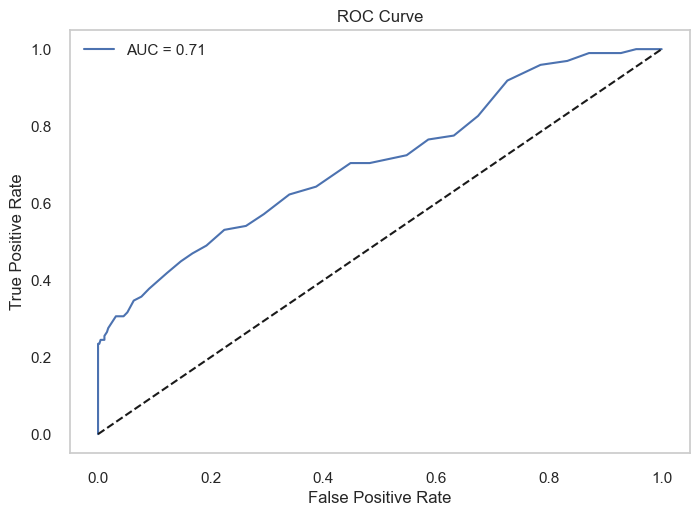

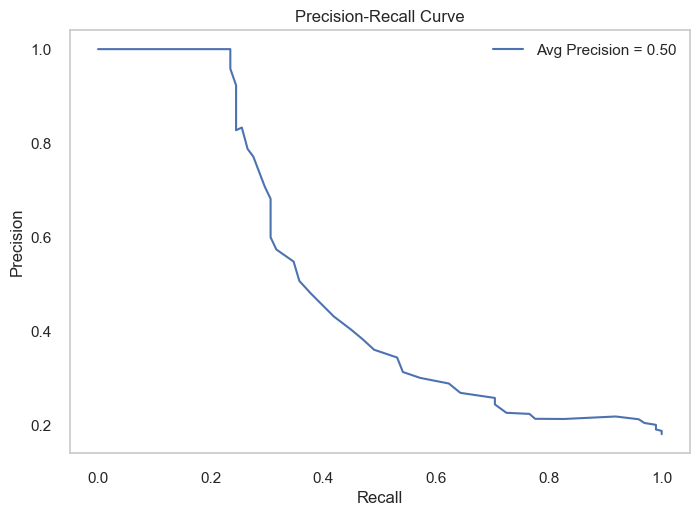

In [188]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, precision_score,
    f1_score, cohen_kappa_score, matthews_corrcoef,
    confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
)

N = 16  # Número de características a seleccionar

# Top N feature selection
top_N_features = feat_imp_df.sort_values(by='Importance', ascending=False).head(N)
print(top_N_features)
top_N_feature_names = top_N_features['Feature'].tolist()

X_topN = X[top_N_feature_names]

# Train/test split
X_train_topN, X_test_topN, y_train, y_test = train_test_split(
    X_topN, y, test_size=0.2, random_state=42
)

# Model training
start_time = time.time()
model_topN = ExtraTreesClassifier()
model_topN.fit(X_train_topN, y_train)
training_time = time.time() - start_time

# Predictions
y_pred = model_topN.predict(X_test_topN)
y_proba = model_topN.predict_proba(X_test_topN)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Display metrics
print(f"Accuracy     : {accuracy:.4f}")
print(f"AUC          : {auc:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Kappa        : {kappa:.4f}")
print(f"MCC          : {mcc:.4f}")
print(f"TT (Sec)     : {training_time:.2f}")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)
plt.plot(recall_vals, precision_vals, label=f"Avg Precision = {avg_prec:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.legend()
plt.show()


In [189]:
#### This will print the 16 features with the highest importance based on your ExtraTreesClassifier.

top_16_features = feat_imp_df.sort_values(by='Importance', ascending=False).head(16)
print(top_16_features)

                       Feature  Importance
0                          AGE    0.033914
13                     HGB_MIN    0.031103
10  CHARLSON_COMORBIDITY_INDEX    0.030855
17                    MCHC_AVG    0.029401
20                     ALT_AVG    0.028624
12                     WBC_AVG    0.028557
2               HOSP_LOS_HOURS    0.028538
5                RESP_RATE_AVG    0.028433
29             DIAGNOSIS_COUNT    0.028404
6                     SPO2_AVG    0.028225
4                      MBP_AVG    0.027854
3               HEART_RATE_AVG    0.027799
18               MONOCYTES_AVG    0.027717
14                 GLUCOSE_AVG    0.027699
19             NEUTROPHILS_AVG    0.027473
9                   SODIUM_AVG    0.027334


Accuracy     : 0.8519
AUC          : 0.7051
Recall       : 0.1837
Precision    : 1.0000
F1 Score     : 0.3103
Kappa        : 0.2692
MCC          : 0.3944
TT (Sec)     : 0.13
Confusion Matrix:
[[442   0]
 [ 80  18]]


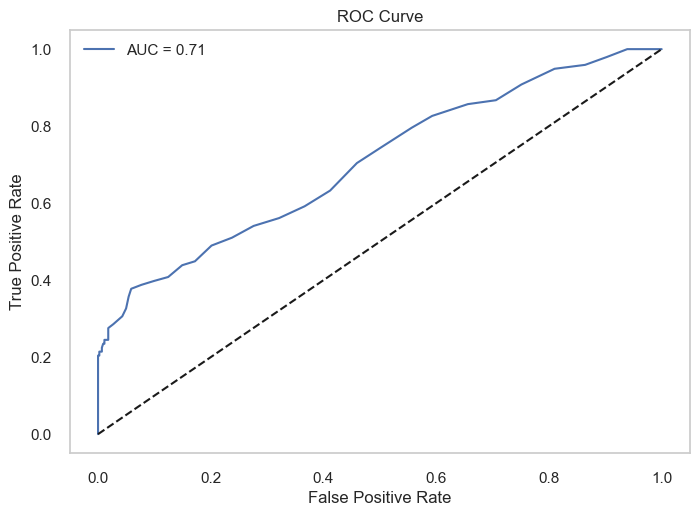

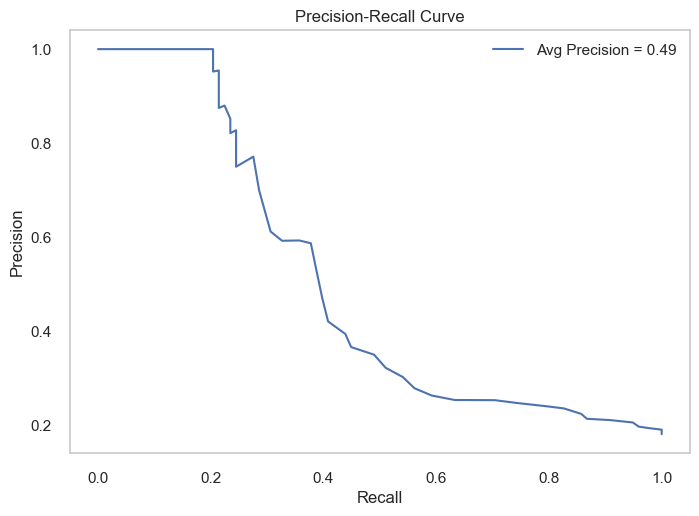

📊 Risk Band Summary:
Risk_Band
Low Risk       477
Medium Risk     45
High Risk       18
Name: count, dtype: int64

📬 High Risk Patients to Alert: 18
🏥 Estimated total readmissions (probability sum): 106.63 out of 540
✅ Test set exported as 'test_set_for_app.csv'


In [190]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, precision_score,
    f1_score, cohen_kappa_score, matthews_corrcoef,
    confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
)

top_16_features = feat_imp_df.sort_values(by='Importance', ascending=False).head(16)
top_16_feature_names = top_16_features['Feature'].tolist()

X_top16 = X[top_16_feature_names]

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, precision_score,
    f1_score, cohen_kappa_score, matthews_corrcoef
)
import time

X_train_top16, X_test_top16, y_train, y_test = train_test_split(
    X_top16, y, test_size=0.2, random_state=42
)

from sklearn.ensemble import ExtraTreesClassifier

# ⏱ Start timer
start_time = time.time()

# Train model
model_top16 = ExtraTreesClassifier()
model_top16.fit(X_train_top16, y_train)

# ⏱ End timer
training_time = time.time() - start_time


# Predictions
y_pred = model_top16.predict(X_test_top16)
y_proba = model_top16.predict_proba(X_test_top16)[:, 1]

# ✅ Metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# 📊 Display results
print(f"Accuracy     : {accuracy:.4f}")
print(f"AUC          : {auc:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Kappa        : {kappa:.4f}")
print(f"MCC          : {mcc:.4f}")
print(f"TT (Sec)     : {training_time:.2f}")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_proba = model_top16.predict_proba(X_test_top16)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

plt.plot(recall, precision, label=f"Avg Precision = {avg_prec:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.legend()
plt.show()

# 📊 --- Stratified Risk-Based Interpretation of Model Output ---

# 🧭 Define risk bands (aligned with clinical messaging)
def risk_band(p):
    if p > 0.5:
        return "High Risk"
    elif p >= 0.3:
        return "Medium Risk"
    else:
        return "Low Risk"

# 🎯 Apply risk band classification
risk_labels = [risk_band(p) for p in y_proba]

# 🧾 Attach to original test set for review/export
X_test_with_risk = X_test_top16.copy()
X_test_with_risk["Probability"] = y_proba
X_test_with_risk["Predicted_Label"] = y_pred
X_test_with_risk["Risk_Band"] = risk_labels

# 💬 Count and describe
print("📊 Risk Band Summary:")
print(X_test_with_risk["Risk_Band"].value_counts())

# 📬 Patients needing action 
high_risk_patients = X_test_with_risk[X_test_with_risk["Risk_Band"] == "High Risk"]
print(f"\n📬 High Risk Patients to Alert: {len(high_risk_patients)}")

# 🏥 Expected readmissions (probabilistic sum)
expected_readmissions = y_proba.sum()
print(f"🏥 Estimated total readmissions (probability sum): {expected_readmissions:.2f} out of {len(y_test)}")

# 📁 Optional: save for clinical teams
# X_test_with_risk.to_csv("predicted_patients_with_risk_bands.csv", index=False)

# ✅ Save test set for app use
X_test_top16["READMITTED"] = y_test.values  # Optional: include ground truth
X_test_top16.to_csv("test_set_for_app.csv", index=False)
print("✅ Test set exported as 'test_set_for_app.csv'")

Accuracy     : 0.7148
AUC          : 0.7235
Recall       : 0.3257
Precision    : 0.7920
F1 Score     : 0.4615
Kappa        : 0.3108
MCC          : 0.3676
Training Time (Sec) : 0.14
Confusion Matrix:
[[480  26]
 [205  99]]


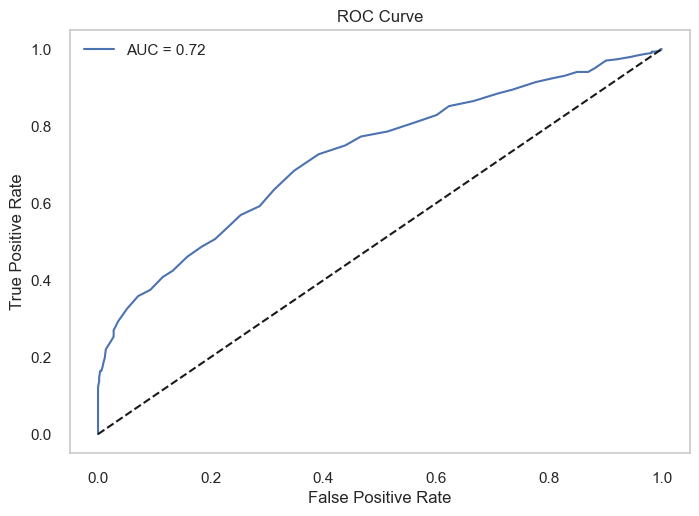

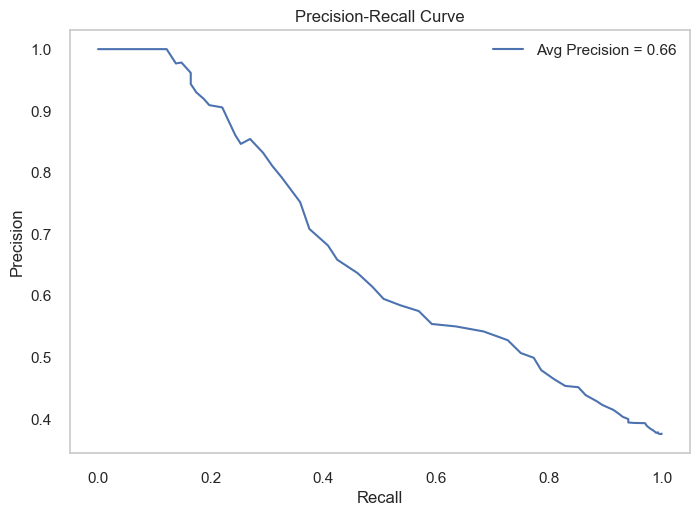

📊 Risk Band Summary:
Risk_Band
Medium Risk    503
Low Risk       182
High Risk      125
Name: count, dtype: int64

📬 High Risk Patients to Alert: 125
🏥 Estimated total readmissions (probability sum): 316.99 out of 810
✅ Test set exported as 'test_set_for_app.csv'


In [185]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, precision_score,
    f1_score, cohen_kappa_score, matthews_corrcoef,
    confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
)

# 📌 Replace with your manual list of selected feature names
manual_features = ["MCHC_AVG", "RESP_RATE_AVG", "MBP_AVG", "SPO2_AVG", "GLUCOSE_AVG", "CHARLSON_COMORBIDITY_INDEX", "NEUTROPHILS_AVG", "AGE", "HGB_MIN", "HEART_RATE_AVG", "WBC_AVG", "MONOCYTES_AVG", "APSIII", "CHLORIDE_AVG", "INR_MAX", "HOSP_LOS_HOURS"]

# ✅ Subset your features manually
X_manual = X[manual_features]  # Make sure `X` and `y` are defined in your context

# 🧪 Train-test split
X_train_manual, X_test_manual, y_train, y_test = train_test_split(
    X_manual, y, test_size=0.3, random_state=42
)

# ⏱ Start timer
start_time = time.time()

# 🧠 Train model
model_manual = ExtraTreesClassifier()
model_manual.fit(X_train_manual, y_train)

# ⏱ End timer
training_time = time.time() - start_time

# 📈 Predictions
y_pred = model_manual.predict(X_test_manual)
y_proba = model_manual.predict_proba(X_test_manual)[:, 1]

# ✅ Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision_val = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# 📊 Display results
print(f"Accuracy     : {accuracy:.4f}")
print(f"AUC          : {auc:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"Precision    : {precision_val:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Kappa        : {kappa:.4f}")
print(f"MCC          : {mcc:.4f}")
print(f"Training Time (Sec) : {training_time:.2f}")

# 🔍 Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 📉 ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# 📉 Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)
plt.plot(recall_vals, precision_vals, label=f"Avg Precision = {avg_prec:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.legend()
plt.show()


# 📊 --- Stratified Risk-Based Interpretation of Model Output ---

# 🧭 Define risk bands (aligned with clinical messaging)
def risk_band(p):
    if p > 0.5:
        return "High Risk"
    elif p >= 0.3:
        return "Medium Risk"
    else:
        return "Low Risk"

# 🎯 Apply risk band classification
risk_labels = [risk_band(p) for p in y_proba]

# 🧾 Attach to original test set for review/export
X_test_with_risk = X_test_manual.copy()
X_test_with_risk["Probability"] = y_proba
X_test_with_risk["Predicted_Label"] = y_pred
X_test_with_risk["Risk_Band"] = risk_labels

# 💬 Count and describe
print("📊 Risk Band Summary:")
print(X_test_with_risk["Risk_Band"].value_counts())

# 📬 Patients needing action 
high_risk_patients = X_test_with_risk[X_test_with_risk["Risk_Band"] == "High Risk"]
print(f"\n📬 High Risk Patients to Alert: {len(high_risk_patients)}")

# 🏥 Expected readmissions (probabilistic sum)
expected_readmissions = y_proba.sum()
print(f"🏥 Estimated total readmissions (probability sum): {expected_readmissions:.2f} out of {len(y_test)}")

# 📁 Optional: save for clinical teams
# X_test_with_risk.to_csv("predicted_patients_with_risk_bands.csv", index=False)

# ✅ Save test set for app use
X_test_manual["READMITTED"] = y_test.values  # Optional: include ground truth
X_test_manual.to_csv("test_set_for_app.csv", index=False)
print("✅ Test set exported as 'test_set_for_app.csv'")



In [19]:
import joblib
joblib.dump(model_manual, 'readmission-risk-app/model/modelo_final.pkl')

['readmission-risk-app/model/modelo_final.pkl']

In [86]:
import json

manual_features = [
    'MCHC_AVG', 'RESP_RATE_AVG', 'MBP_AVG', 'SPO2_AVG', 'GLUCOSE_AVG',
    'CHARLSON_COMORBIDITY_INDEX', 'NEUTROPHILS_AVG', 'AGE', 'HGB_MIN',
    'HEART_RATE_AVG', 'WBC_AVG', 'MONOCYTES_AVG', 'APSIII',
    'CHLORIDE_AVG', 'INR_MAX', 'HOSP_LOS_HOURS'
]

with open("manual_features.json", "w") as f:
    json.dump(manual_features, f)

print("✅ Saved manual_features.json")

✅ Saved manual_features.json
